A quick recap on the difference between classification and regression :

With classification, we attempt to predict a class label. In other words, it is used for problems where the output (target variable) takes a finite set of values, e.g., whether it will rain tomorrow or not. Corresponding algorithm: sklearn.ensemble.RandomForestClassifier
Meanwhile, regression is used to predict a numerical label. This means your output can take an infinite set of values, e.g., a house price. Corresponding algorithm:sklearn.ensemble.RandomForestRegressor

Random Forest algorithm uses majority agreement prediction for the class label, which means that each tree predicts whether the observation belongs to ‘Class 0’ or ‘Class 1’. If 55 trees out of a hundred predicted ‘Class 1’ and 45 predicted ‘Class 0’, then the final model prediction would be ‘Class 1’.

The majority prediction from multiple trees is better than an individual tree prediction because the trees protect each other from their individual errors. This is, however, dependant on the trees being relatively uncorrelated with each other.

In [1]:
import pandas as pd # for data manipulation
import numpy as np # for data manipulation

from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn import tree # for decision tree models
from sklearn.ensemble import RandomForestClassifier

import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization
import graphviz # for plotting decision tree graphs

In [2]:
# Set Pandas options to display more columns
pd.options.display.max_columns=50

# Read in the weather data csv
df=pd.read_csv('C:/Users/Admin/Machine Learning chapter 5/weatherAUS.csv', encoding='utf-8')

# Drop records where target RainTomorrow=NaN
df=df[pd.isnull(df['RainTomorrow'])==False]

# For other columns with missing values, fill them in with column mean
df=df.fillna(df.mean())

# Create a flag for RainToday and RainTomorrow, note RainTomorrowFlag will be our target variable
df['RainTodayFlag']=df['RainToday'].apply(lambda x: 1 if x=='Yes' else 0)
df['RainTomorrowFlag']=df['RainTomorrow'].apply(lambda x: 1 if x=='Yes' else 0)

# Show a snaphsot of data
df

C:\Users\Admin\AppData\Local\Temp/ipykernel_10908/595407759.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df=df.fillna(df.mean())


Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6     5.469824   
1       2008-12-02   Albury      7.4     25.1       0.0     5.469824   
2       2008-12-03   Albury     12.9     25.7       0.0     5.469824   
3       2008-12-04   Albury      9.2     28.0       0.0     5.469824   
4       2008-12-05   Albury     17.5     32.3       1.0     5.469824   
...            ...      ...      ...      ...       ...          ...   
145454  2017-06-20    Uluru      3.5     21.8       0.0     5.469824   
145455  2017-06-21    Uluru      2.8     23.4       0.0     5.469824   
145456  2017-06-22    Uluru      3.6     25.3       0.0     5.469824   
145457  2017-06-23    Uluru      5.4     26.9       0.0     5.469824   
145458  2017-06-24    Uluru      7.8     27.0       0.0     5.469824   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
0       7.624853           W           44.0          W        WNW   
1       7.624853         WNW           44.0        NNW        WSW   
2       7.624853         WSW           46.0          W        WSW   
3       7.624853          NE           24.0         SE          E   
4       7.624853           W           41.0        ENE         NW   
...          ...         ...            ...        ...        ...   
145454  7.624853           E           31.0        ESE          E   
145455  7.624853           E           31.0         SE        ENE   
145456  7.624853         NNW           22.0         SE          N   
145457  7.624853           N           37.0         SE        WNW   
145458  7.624853          SE           28.0        SSE          N   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0               20.0          24.0         71.0         22.0       1007.7   
1                4.0          22.0         44.0         25.0       1010.6   
2               19.0          26.0         38.0         30.0       1007.6   
3               11.0           9.0         45.0         16.0       1017.6   
4                7.0          20.0         82.0         33.0       1010.8   
...              ...           ...          ...          ...          ...   
145454          15.0          13.0         59.0         27.0       1024.7   
145455          13.0          11.0         51.0         24.0       1024.6   
145456          13.0           9.0         56.0         21.0       1023.5   
145457           9.0           9.0         53.0         24.0       1021.0   
145458          13.0           7.0         51.0         24.0       1019.4   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm RainToday  \
0            1007.1  8.000000  4.503167     16.9     21.8        No   
1            1007.8  4.437189  4.503167     17.2     24.3        No   
2            1008.7  4.437189  2.000000     21.0     23.2        No   
3            1012.8  4.437189  4.503167     18.1     26.5        No   
4            1006.0  7.000000  8.000000     17.8     29.7        No   
...             ...       ...       ...      ...      ...       ...   
145454       1021.2  4.437189  4.503167      9.4     20.9        No   
145455       1020.3  4.437189  4.503167     10.1     22.4        No   
145456       1019.1  4.437189  4.503167     10.9     24.5        No   
145457       1016.8  4.437189  4.503167     12.5     26.1        No   
145458       1016.5  3.000000  2.000000     15.1     26.0        No   

       RainTomorrow  RainTodayFlag  RainTomorrowFlag  
0                No              0                 0  
1                No              0                 0  
2                No              0                 0  
3                No              0                 0  
4                No              0                 0  
...             ...            ...               ...  
145454           No              0                 0  
145455           No              0                 0  
145456           No              0             

In [3]:
##### Step 1 - Select data for modeling
X=df[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 
      'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',  
      'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainTodayFlag']]
y=df['RainTomorrowFlag'].values

In [4]:
##### Step 2 - Create training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
##### Step 3
# Set model and its parameters
model = RandomForestClassifier(criterion='gini', 
                               bootstrap=True, # enabling bootstrapping
                               random_state=0, # random state for reproducibility
                               max_features='sqrt', # number of random features to use sqrt(n_features)
                               min_samples_leaf=1000, # minimum no of observarions allowed in a leaf
                               max_depth=4, # maximum depth of the tree
                               n_estimators=1000 # how many trees to build
                              )

In [6]:
# Fit the model
clf = model.fit(X_train, y_train)


##### Step 4
# Predict class labels on training data
pred_labels_tr = model.predict(X_train)
# Predict class labels on a test data
pred_labels_te = model.predict(X_test)

In [7]:
##### Step 5 - Model summary
# Basic info about the model
print('*************** Model Summary ***************')
print('Classes: ', clf.classes_)
print('No. of outputs: ', clf.n_outputs_)
print('No. of features: ', clf.n_features_in_)
print('No. of Estimators: ', len(clf.estimators_))
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Test Data ***************')
score_te = model.score(X_test, y_test)
print('Accuracy Score: ', score_te)
# Look at classification report to evaluate the model
print(classification_report(y_test, pred_labels_te))
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Training Data ***************')
score_tr = model.score(X_train, y_train)
print('Accuracy Score: ', score_tr)
# Look at classification report to evaluate the model
print(classification_report(y_train, pred_labels_tr))
print('--------------------------------------------------------')

*************** Model Summary ***************
Classes:  [0 1]
No. of outputs:  1
No. of features:  17
No. of Estimators:  1000
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.8345933401315095
              precision    recall  f1-score   support

           0       0.84      0.98      0.90     22067
           1       0.80      0.35      0.48      6372

    accuracy                           0.83     28439
   macro avg       0.82      0.66      0.69     28439
weighted avg       0.83      0.83      0.81     28439

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.8326036886614976
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     88249
           1       0.79      0.34      0.48     25505

    accuracy                           0.83    113754
   macro avg       0.81 

Bonus code
While we cannot easily visualize all model predictions using 17 features, we can do it when we build a random forest with just 2 features. For this, we first need to build another model using the code above, remembering to select only 2 features

In [8]:
X=df[['WindGustSpeed', 'Humidity3pm']]

In [9]:
##### Step 2 - Create training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
##### Step 3
# Set model and its parameters
model_2 = RandomForestClassifier(criterion='gini', 
                               bootstrap=True, # enabling bootstrapping
                               random_state=0, # random state for reproducibility
                               max_features='sqrt', # number of random features to use sqrt(n_features)
                               min_samples_leaf=1000, # minimum no of observarions allowed in a leaf
                               max_depth=4, # maximum depth of the tree
                               n_estimators=1000 # how many trees to build
                              )

In [11]:
# Fit the model
clf = model_2.fit(X_train, y_train)


##### Step 4
# Predict class labels on training data
pred_labels_tr = clf.predict(X_train)
# Predict class labels on a test data
pred_labels_te = clf.predict(X_test)

In [12]:
##### Define a function to generate a 3D graph
def Plot_3D(X, X_test, y_test, clf, x1, x2, mesh_size, margin):
            
    # Specify a size of the mesh to be used
    mesh_size=mesh_size
    margin=margin

    # Create a mesh grid on which we will run our model
    x_min, x_max = X.iloc[:, 0].fillna(X.mean()).min() - margin, X.iloc[:, 0].fillna(X.mean()).max() + margin
    y_min, y_max = X.iloc[:, 1].fillna(X.mean()).min() - margin, X.iloc[:, 1].fillna(X.mean()).max() + margin
    xrange = np.arange(x_min, x_max, mesh_size)
    yrange = np.arange(y_min, y_max, mesh_size)
    xx, yy = np.meshgrid(xrange, yrange)
            
    # Calculate predictions on grid
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)

    # Create a 3D scatter plot with predictions
    fig = px.scatter_3d(x=X_test[x1], y=X_test[x2], z=y_test, opacity=0.8, color_discrete_sequence=['black'])

    # Set figure title and colors
    fig.update_layout(#title_text="Scatter 3D Plot with Random Forest Prediction Surface",
                      paper_bgcolor = 'white',
                      scene = dict(xaxis=dict(title=x1,
                                              backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0'),
                                   yaxis=dict(title=x2,
                                              backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0'
                                              ),
                                   zaxis=dict(title='Probability of Rain Tomorrow',
                                              backgroundcolor='lightgrey',
                                              color='black', 
                                              gridcolor='#f0f0f0', 
                                              )))
    
    # Update marker size
    fig.update_traces(marker=dict(size=1))

    # Add prediction plane
    fig.add_traces(go.Surface(x=xrange, y=yrange, z=Z, name='Random Forest Prediction',
                              colorscale='Bluered',
                              reversescale=True,
                              showscale=False, 
                              contours = {"z": {"show": True, "start": 0.5, "end": 0.9, "size": 0.5}}))
    fig.show()
    return fig

In [13]:
##### Call the above function
fig = Plot_3D(X, X_test, y_test, clf, x1='WindGustSpeed', x2='Humidity3pm', mesh_size=1, margin=1)

C:\Users\Admin\anacondalastone\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


# from the above visualization, we can clearly see that chances of rain tomorrow increase as the humidity at 3 pm and wind gust speed increases.But Humdity has more influence since the probability is high to rain tomorrow regardless of the values of wind. 

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('C:/Users/Admin/Machine Learning chapter 5/train.csv')
data

id  gender    age dependents  lifetime phone_services  \
0     1689    Male  30-45        Yes         7             No   
1      794  Female  18-30         No         6             No   
2     4211    Male    >60         No        24            Yes   
3     3318    Male  18-30         No        10             No   
4     5245  Female  30-45        Yes        70            Yes   
...    ...     ...    ...        ...       ...            ...   
2595  4410  Female  30-45         No        16            Yes   
2596  3447    Male  18-30         No        39            Yes   
2597  5292    Male  18-30         No        46             No   
2598  5026    Male  30-45        Yes        23            Yes   
2599  5744    Male  45-60         No        40            Yes   

     internet_services online_streaming multiple_connections premium_plan  \
0                   3G       Major User                  NaN           No   
1                   3G       Major User                  NaN           No   
2                   4G       Major User                  Yes           No   
3                   3G               No                  NaN           No   
4                  NaN              NaN                   No          NaN   
...                ...              ...                  ...          ...   
2595                4G       Major User                   No           No   
2596                4G               No                  Yes           No   
2597                3G               No                  NaN          Yes   
2598               NaN              NaN                   No          NaN   
2599                3G        Sometimes                   No           No   

     online_protect   contract_plan ebill_services  default_payment  \
0               Yes  Month-to-month             No         Physical   
1                No  Month-to-month             No     Auto-payment   
2               Yes  Month-to-month            Yes     Auto-payment   
3               Yes  Month-to-month             No         Physical   
4               NaN        Two year            Yes     Auto-payment   
...             ...             ...            ...              ...   
2595             No  Month-to-month            Yes     Auto-payment   
2596             No        One year             No     Auto-payment   
2597            Yes        One year             No     Auto-payment   
2598            NaN        One year            Yes     Auto-payment   
2599             No        One year             No  Online Transfer   

      monthly_charges  issues exit_status  
0               58.85       2          No  
1               45.00       6          No  
2              102.95      22         Yes  
3               29.50      28         Yes  
4               20.15      13          No  
...               ...     ...         ...  
2595            94.65      10          No  
2596            81.40       3          No  
2597            33.70      16          No  
2598            20.00       7          No  
2599            55.80      11          No  

[2600 rows x 17 columns]

In [16]:
data.isnull().sum()

id                        0
gender                    0
age                       0
dependents                0
lifetime                  0
phone_services            0
internet_services       259
online_streaming        458
multiple_connections    241
premium_plan            458
online_protect          458
contract_plan             0
ebill_services            0
default_payment           0
monthly_charges           0
issues                    0
exit_status               0
dtype: int64

As expected, there are NAs in test.csv. Hence, we will treat NAs as a category and assume it contributes to the response variable exit_status. Nan will not be removed since they are in the test data. 

Replace Yes-No in exit_status to 1–0

In [17]:
exit_status_map = {'Yes': 1, 'No': 0}
data['exit_status'] = data['exit_status'].map(exit_status_map)

Split the data into X and y

In [18]:
y = data.pop('exit_status')

In [19]:
y

0       0
1       0
2       1
3       1
4       0
       ..
2595    0
2596    0
2597    0
2598    0
2599    0
Name: exit_status, Length: 2600, dtype: int64

In [20]:
data.columns

Index(['id', 'gender', 'age', 'dependents', 'lifetime', 'phone_services',
       'internet_services', 'online_streaming', 'multiple_connections',
       'premium_plan', 'online_protect', 'contract_plan', 'ebill_services',
       'default_payment', 'monthly_charges', 'issues'],
      dtype='object')

In [21]:
X = data.drop('id',axis = 1)

In [22]:
seed = 50  # so that the result is reproducible
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.333, random_state = seed)

Now, it is time to make NA a category. In Python, NaN is considered NAs. When encoded, those NaN will be ignored. Hence, it is useful to replace NaN with na, which is now a category called ‘na’. This will be taken into account when encoding later on.

In [23]:
X_train = X_train.fillna('na')
X_test = X_test.fillna('na')

In [24]:
X_train.dtypes

gender                   object
age                      object
dependents               object
lifetime                  int64
phone_services           object
internet_services        object
online_streaming         object
multiple_connections     object
premium_plan             object
online_protect           object
contract_plan            object
ebill_services           object
default_payment          object
monthly_charges         float64
issues                    int64
dtype: object

In [25]:
features_to_encode = X_train.columns[X_train.dtypes==object].tolist()
features_to_encode

['gender',
 'age',
 'dependents',
 'phone_services',
 'internet_services',
 'online_streaming',
 'multiple_connections',
 'premium_plan',
 'online_protect',
 'contract_plan',
 'ebill_services',
 'default_payment']

In [26]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
col_trans = make_column_transformer(
                        (OneHotEncoder(),features_to_encode),
                        remainder = "passthrough"
                        )

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(
                      min_samples_leaf=50,
                      n_estimators=150,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=seed,
                      max_features='sqrt')

In [28]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(col_trans, rf_classifier)
Model = pipe.fit(X_train, y_train)

In [29]:
y_pred = pipe.predict(X_test)
y_pred.shape

(866,)

In [30]:
y_test.shape

(866,)

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [32]:
from sklearn.metrics import classification_report

In [33]:
score_te = Model.score(X_test, y_test)
score_te

0.9110854503464203

In [34]:
score_train = Model.score(X_train, y_train)
score_train

0.9204152249134948

In [35]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       449
           1       0.90      0.92      0.91       417

    accuracy                           0.91       866
   macro avg       0.91      0.91      0.91       866
weighted avg       0.91      0.91      0.91       866



In [36]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
        fontsize = 20,
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [37]:
from sklearn.metrics import confusion_matrix

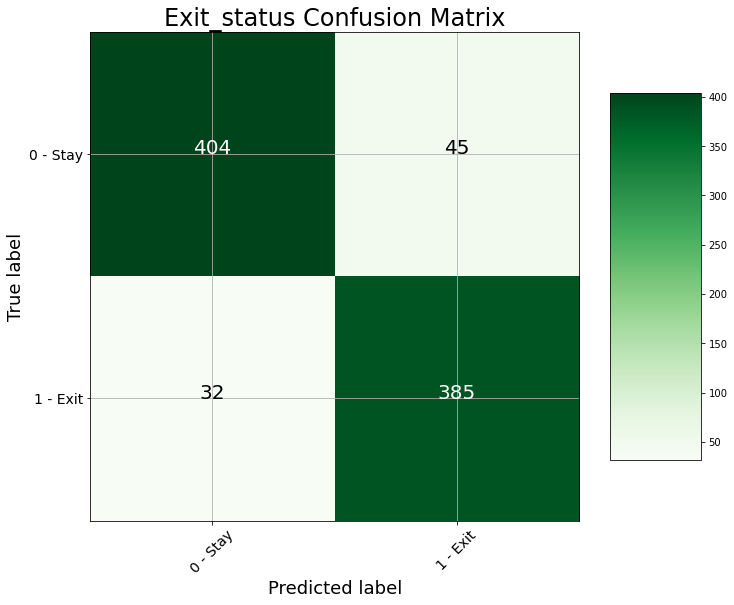

In [38]:
# Let's plot it out
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['0 - Stay', '1 - Exit'],
                      title = 'Exit_status Confusion Matrix')

In [39]:
X_train.columns

Index(['gender', 'age', 'dependents', 'lifetime', 'phone_services',
       'internet_services', 'online_streaming', 'multiple_connections',
       'premium_plan', 'online_protect', 'contract_plan', 'ebill_services',
       'default_payment', 'monthly_charges', 'issues'],
      dtype='object')

In [40]:
print(rf_classifier.feature_importances_)
print(f" There are {len(rf_classifier.feature_importances_)} features in total")

[7.41626071e-04 6.12165359e-04 1.42322746e-03 6.93254520e-03
 2.93650843e-04 1.96706074e-04 1.85830433e-03 2.67517842e-03
 1.02110066e-05 2.99006245e-05 6.15325794e-03 1.66647237e-02
 4.49100748e-03 3.37963818e-05 1.87449830e-03 1.00225588e-03
 3.72119245e-04 1.39558189e-02 8.28073088e-04 3.41692010e-04
 1.71733193e-04 7.60943914e-02 1.09485070e-02 1.78380970e-02
 1.63392715e-02 2.93397339e-03 1.46445733e-02 1.34849432e-01
 1.33144331e-02 4.42753783e-02 3.13204793e-03 4.97894324e-03
 6.17692498e-03 2.70959923e-02 1.61849449e-03 7.57024010e-02
 2.31468190e-02 4.66247828e-01]
 There are 38 features in total


There are 38 features in total. However, there are only 15 columns in X_train. This is because the model pipe automatically encodes the categorical variables in X_train. For example, the gender column in X_train is transformed into 2 columns Female and Male.

In [41]:
# Let's look at the first row
print(col_trans.fit_transform(X_train)[0,:])

[ 0.    1.    0.    0.    0.    1.    1.    0.    0.    1.    1.    0.
  0.    0.    1.    0.    0.    0.    1.    0.    0.    1.    0.    0.
  1.    0.    0.    1.    0.    0.    0.    1.    0.    1.    0.   30.
 74.75 14.  ]


In [42]:
# And the first row of X_train
X_train.iloc[0,:]    

gender                             Male
age                                 >60
dependents                           No
lifetime                             30
phone_services                      Yes
internet_services                    3G
online_streaming             Major User
multiple_connections                 No
premium_plan                         No
online_protect                       No
contract_plan            Month-to-month
ebill_services                      Yes
default_payment         Online Transfer
monthly_charges                   74.75
issues                               14
Name: 1258, dtype: object

For X_train, there are 3 numeric variables, with values being 30, 70.75 and 14 respectively. For the encoded X_train, these 3 numeric values are placed after all the categorical variables. This means that for the rf_classifier.feature_importances_ all the encoded categorical variables are shown first, followed by the numeric variables

In [43]:
dummies = pd.get_dummies(X_train[features_to_encode])
dummies

gender_Female  gender_Male  age_18-30  age_30-45  age_45-60  age_>60  \
1258              0            1          0          0          0        1   
1812              1            0          0          1          0        0   
270               1            0          1          0          0        0   
1807              1            0          0          1          0        0   
1113              1            0          0          0          0        1   
...             ...          ...        ...        ...        ...      ...   
2014              1            0          0          1          0        0   
2157              1            0          0          1          0        0   
1931              0            1          1          0          0        0   
1504              1            0          0          1          0        0   
1712              0            1          1          0          0        0   

      dependents_No  dependents_Yes  phone_services_No  phone_services_Yes  \
1258              1               0                  0                   1   
1812              0               1                  0                   1   
270               1               0                  0                   1   
1807              0               1                  0                   1   
1113              1               0                  0                   1   
...             ...             ...                ...                 ...   
2014              1               0                  0                   1   
2157              0               1                  0                   1   
1931              0               1                  0                   1   
1504              1               0                  0                   1   
1712              1               0                  0                   1   

      internet_services_3G  internet_services_4G  internet_services_None  \
1258                     1                     0                       0   
1812                     0                     0                       1   
270                      0                     1                       0   
1807                     0                     0                       0   
1113                     0                     1                       0   
...                    ...                   ...                     ...   
2014                     1                     0                       0   
2157                     0                     0                       0   
1931                     0                     0                       0   
1504                     0                     1                       0   
1712                     0                     0                       1   

      internet_services_na  online_streaming_Major User  online_streaming_No  \
1258                     0                            1                    0   
1812                     0                            0                    0   
270                      0                            0                    0   
1807                     1                            0                    0   
1113                     0                            0                    1   
...                    ...                          ...                  ...   
2014                     0                            0                    1   
2157                     1                            0                    0   
1931                     1                            0                    1   
1504                     0                            1                    0   
1712                     0                            0                    0   

      online_streaming_Sometimes  online_streaming_na  \
1258                           0                    0   
1812                           0                    1   
270                            1                    0   
1807                          

In [44]:
def encode_and_bind(original_dataframe, features_to_encode):
    dummies = pd.get_dummies(original_dataframe[features_to_encode])
    res = pd.concat([dummies, original_dataframe], axis=1)
    res = res.drop(features_to_encode, axis=1)
    return(res)
X_train_encoded = encode_and_bind(X_train, features_to_encode)
X_train_encoded

gender_Female  gender_Male  age_18-30  age_30-45  age_45-60  age_>60  \
1258              0            1          0          0          0        1   
1812              1            0          0          1          0        0   
270               1            0          1          0          0        0   
1807              1            0          0          1          0        0   
1113              1            0          0          0          0        1   
...             ...          ...        ...        ...        ...      ...   
2014              1            0          0          1          0        0   
2157              1            0          0          1          0        0   
1931              0            1          1          0          0        0   
1504              1            0          0          1          0        0   
1712              0            1          1          0          0        0   

      dependents_No  dependents_Yes  phone_services_No  phone_services_Yes  \
1258              1               0                  0                   1   
1812              0               1                  0                   1   
270               1               0                  0                   1   
1807              0               1                  0                   1   
1113              1               0                  0                   1   
...             ...             ...                ...                 ...   
2014              1               0                  0                   1   
2157              0               1                  0                   1   
1931              0               1                  0                   1   
1504              1               0                  0                   1   
1712              1               0                  0                   1   

      internet_services_3G  internet_services_4G  internet_services_None  \
1258                     1                     0                       0   
1812                     0                     0                       1   
270                      0                     1                       0   
1807                     0                     0                       0   
1113                     0                     1                       0   
...                    ...                   ...                     ...   
2014                     1                     0                       0   
2157                     0                     0                       0   
1931                     0                     0                       0   
1504                     0                     1                       0   
1712                     0                     0                       1   

      internet_services_na  online_streaming_Major User  online_streaming_No  \
1258                     0                            1                    0   
1812                     0                            0                    0   
270                      0                            0                    0   
1807                     1                            0                    0   
1113                     0                            0                    1   
...                    ...                          ...                  ...   
2014                     0                            0                    1   
2157                     1                            0                    0   
1931                     1                            0                    1   
1504                     0                            1                    0   
1712                     0                            0                    0   

      online_streaming_Sometimes  online_streaming_na  \
1258                           0                    0   
1812                           0                    1   
270                            1                    0   
1807                          

In [45]:
feature_importances = list(zip(X_train_encoded, rf_classifier.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];

Feature: issues                              Importance: 0.46624782846326046
Feature: contract_plan_Month-to-month        Importance: 0.1348494321203859
Feature: premium_plan_No                     Importance: 0.07609439137797289
Feature: lifetime                            Importance: 0.07570240099772282
Feature: contract_plan_Two year              Importance: 0.04427537832458953
Feature: default_payment_Online Transfer     Importance: 0.027095992311968936
Feature: monthly_charges                     Importance: 0.023146819033694803
Feature: premium_plan_na                     Importance: 0.01783809701516951
Feature: internet_services_4G                Importance: 0.016664723657875163
Feature: online_protect_No                   Importance: 0.01633927147353242
Feature: online_protect_na                   Importance: 0.014644573293332979
Feature: online_streaming_na                 Importance: 0.013955818858399235
Feature: contract_plan_One year              Importance: 0.0133144331397

In [46]:
feature_importances

[('gender_Female', 0.0007416260707024659),
 ('gender_Male', 0.0006121653589026648),
 ('age_18-30', 0.0014232274613008087),
 ('age_30-45', 0.0069325451952310605),
 ('age_45-60', 0.0002936508430450104),
 ('age_>60', 0.0001967060740776274),
 ('dependents_No', 0.0018583043341081184),
 ('dependents_Yes', 0.002675178424638892),
 ('phone_services_No', 1.0211006602026162e-05),
 ('phone_services_Yes', 2.990062450428182e-05),
 ('internet_services_3G', 0.0061532579446535295),
 ('internet_services_4G', 0.016664723657875163),
 ('internet_services_None', 0.004491007481458802),
 ('internet_services_na', 3.37963818461236e-05),
 ('online_streaming_Major User', 0.0018744982957409804),
 ('online_streaming_No', 0.0010022558843243397),
 ('online_streaming_Sometimes', 0.00037211924457143935),
 ('online_streaming_na', 0.013955818858399235),
 ('multiple_connections_No', 0.0008280730877387723),
 ('multiple_connections_Yes', 0.0003416920097474029),
 ('multiple_connections_na', 0.00017173319339582619),
 ('premiu

In [47]:
feature_importances_ranked

[('issues', 0.46624782846326046),
 ('contract_plan_Month-to-month', 0.1348494321203859),
 ('premium_plan_No', 0.07609439137797289),
 ('lifetime', 0.07570240099772282),
 ('contract_plan_Two year', 0.04427537832458953),
 ('default_payment_Online Transfer', 0.027095992311968936),
 ('monthly_charges', 0.023146819033694803),
 ('premium_plan_na', 0.01783809701516951),
 ('internet_services_4G', 0.016664723657875163),
 ('online_protect_No', 0.01633927147353242),
 ('online_protect_na', 0.014644573293332979),
 ('online_streaming_na', 0.013955818858399235),
 ('contract_plan_One year', 0.013314433139782903),
 ('premium_plan_Yes', 0.010948506982551433),
 ('age_30-45', 0.0069325451952310605),
 ('default_payment_Auto-payment', 0.006176924976009681),
 ('internet_services_3G', 0.0061532579446535295),
 ('ebill_services_Yes', 0.004978943244038694),
 ('internet_services_None', 0.004491007481458802),
 ('ebill_services_No', 0.003132047929996559),
 ('online_protect_Yes', 0.0029339733928798644),
 ('dependents

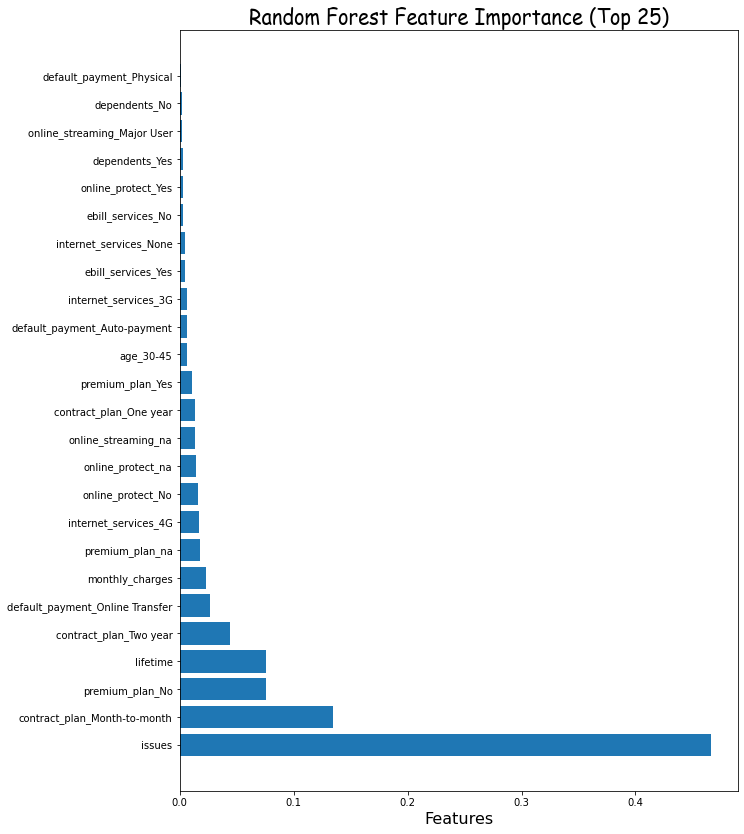

In [48]:
# Plot the top 25 feature importance
feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
y_ticks = np.arange(0, len(feature_names_25))
x_axis = [i[1] for i in feature_importances_ranked[:25]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_25, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance (Top 25)',
          fontdict= {'fontname':'Comic Sans MS','fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

In [49]:
from pprint import pprint
print('Parameters currently in use:\n')
pprint(rf_classifier.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 50,
 'verbose': 0,
 'warm_start': False}


# How to tune the random forest alghoritm. Using RandomizedSearchCV

In [91]:
from sklearn.model_selection import RandomizedSearchCV

In [92]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 50)]
max_features = ['log2']  # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]   # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10]  # Minimum number of samples required to split a node
min_samples_leaf = [1, 4, 10]    # Minimum number of samples required at each leaf node
bootstrap = [True, False]       # Method of selecting samples for training each tree
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
               'bootstrap': bootstrap}

In [50]:
col_trans

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['gender', 'age', 'dependents',
                                  'phone_services', 'internet_services',
                                  'online_streaming', 'multiple_connections',
                                  'premium_plan', 'online_protect',
                                  'contract_plan', 'ebill_services',
                                  'default_payment'])])

In [93]:
rf = RandomForestClassifier(oob_score=True, n_jobs=-1)
rf_random = RandomizedSearchCV(
                estimator = rf,
                param_distributions = random_grid,
                n_iter = 50, cv = 3,
                verbose=1, random_state=seed,)
pipe_random = make_pipeline(col_trans, rf_random)

In [94]:
pipe_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\Admin\anacondalastone\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning:


78 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anacondalastone\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anacondalastone\lib\site-packages\sklearn\ensemble\_forest.py", line 434, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimation only available if bootstrap=True


C:\Users\Admin\anacondalastone\lib\site-pack

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['gender', 'age',
                                                   'dependents',
                                                   'phone_services',
                                                   'internet_services',
                                                   'online_streaming',
                                                   'multiple_connections',
                                                   'premium_plan',
                                                   'online_protect',
                                                   'contract_plan',
                                                   'ebill_services',
                                                   'default_payment'])])),
                ('randomizedsearchcv',
                 Random...
                                                         'max_features': ['log2'],
                                                         'max_leaf_nodes': [None,
                                                                            10,
                                                                            10,
                                                                            10,
                                                                            10,
                                                                            10,
                                                                            10,
                                                                            10,
                                                                            10,
                                                                            10,
                                                                            10,
                                                                            10,
                                                                            10,
                                                                            10,
                                                                            11,
                                                                            11,
                                                                            11,
                                                                            11,
                                                                            11,
                                                                            11,
                                                                            11,
                                                                            11,
                                                                            11,
                                                                            11,
                                                                            11,
                                                                            11,
                                                                            12,
                                                                            12,
                                                                            12,
                                                                            12, ...],
                                                         'min_samples_leaf': [1,
                                                                              4,
                                                                              10],
                                                         'min_samples_split': [2,
                                                                               5,
                                  

In [95]:
rf_random.best_params_

{'n_estimators': 210,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 48,
 'max_features': 'log2',
 'max_depth': 40,
 'bootstrap': True}

In [97]:
# Use the best model after tuning
best_model = rf_random.best_params_

In [102]:
best_model

{'n_estimators': 210,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 48,
 'max_features': 'log2',
 'max_depth': 40,
 'bootstrap': True}

In [104]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=40, max_features='log2', max_leaf_nodes=48,
                       min_samples_split=10, n_estimators=210, n_jobs=-1,
                       oob_score=True)

In [105]:
Best_model_2 = rf_random.best_estimator_

In [106]:
# To look at nodes and depths of trees use on average
n_nodes = []
max_depths = []
for ind_tree in Best_model_2.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
print(f'Average number of nodes {int(np.mean(n_nodes))}')   
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 95
Average maximum depth 10


In [107]:
#Use the best model after tuning
pipe_best_model = make_pipeline(col_trans, Best_model_2)

In [108]:
Pipe_Best = pipe_best_model.fit(X_train, y_train)
Pipe_Best

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['gender', 'age',
                                                   'dependents',
                                                   'phone_services',
                                                   'internet_services',
                                                   'online_streaming',
                                                   'multiple_connections',
                                                   'premium_plan',
                                                   'online_protect',
                                                   'contract_plan',
                                                   'ebill_services',
                                                   'default_payment'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=40, max_features='log2',
                                        max_leaf_nodes=48, min_samples_split=10,
                                        n_estimators=210, n_jobs=-1,
                                        oob_score=True))])

In [109]:
y_pred_best_model = Pipe_Best.predict(X_test)

In [110]:
y_pred_best_model.shape

(866,)

In [112]:
y_test.shape

(866,)

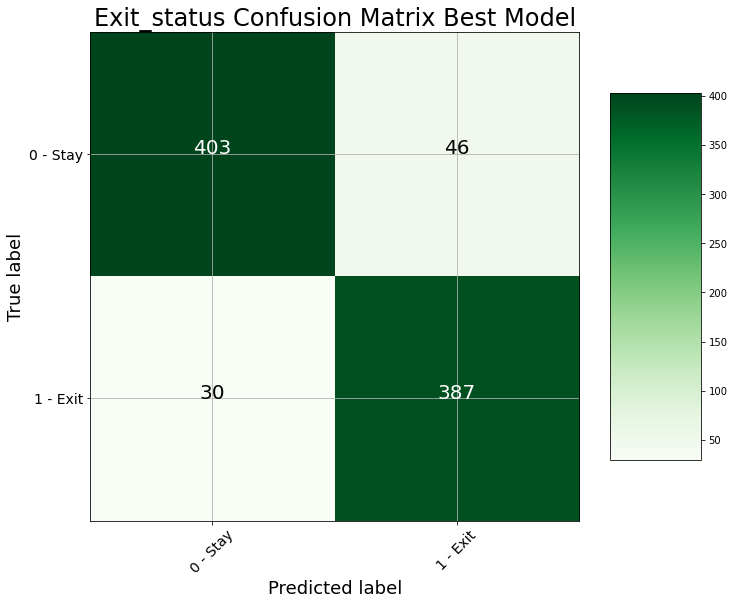

In [114]:
# Plot Confusion matrix
plot_confusion_matrix(confusion_matrix(y_test, y_pred_best_model), classes = ['0 - Stay', '1 - Exit'],
title = 'Exit_status Confusion Matrix Best Model')

In [115]:
print(classification_report(y_test,y_pred_best_model))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       449
           1       0.89      0.93      0.91       417

    accuracy                           0.91       866
   macro avg       0.91      0.91      0.91       866
weighted avg       0.91      0.91      0.91       866



# Use the best model on test.csv data
Now that we have the best model, let’s use it for predictions and compile our final answer to submit.

In [117]:
test = pd.read_csv('C:/Users/Admin/Machine Learning chapter 5/test_Random_Forest.csv')

In [118]:
test

id  gender    age dependents  lifetime phone_services  \
0     3186  Female  30-45        Yes        58            Yes   
1     5531    Male  30-45        Yes        68             No   
2     5264    Male  45-60         No        69             No   
3     3161    Male  18-30         No        14            Yes   
4     3699  Female  30-45         No        30            Yes   
...    ...     ...    ...        ...       ...            ...   
1334  6110  Female  30-45         No        19            Yes   
1335  1493    Male  18-30         No        11            Yes   
1336   145  Female  30-45        Yes        65            Yes   
1337  4952    Male  18-30         No         2            Yes   
1338  5730    Male  18-30         No        67            Yes   

     internet_services online_streaming multiple_connections premium_plan  \
0                 None              NaN                   No          NaN   
1                   3G        Sometimes                  NaN           No   
2                   3G               No                  NaN           No   
3                 None              NaN                   No          NaN   
4                   3G        Sometimes                   No          Yes   
...                ...              ...                  ...          ...   
1334                3G        Sometimes                   No           No   
1335                4G               No                   No           No   
1336                4G        Sometimes                  Yes          Yes   
1337                4G       Major User                   No           No   
1338              None              NaN                   No          NaN   

     online_protect   contract_plan ebill_services  default_payment  \
0               NaN        Two year             No     Auto-payment   
1                No        One year             No         Physical   
2               Yes        One year            Yes     Auto-payment   
3               NaN        One year             No         Physical   
4               Yes        One year             No     Auto-payment   
...             ...             ...            ...              ...   
1334             No  Month-to-month            Yes         Physical   
1335            Yes  Month-to-month            Yes     Auto-payment   
1336             No        Two year            Yes     Auto-payment   
1337             No  Month-to-month             No  Online Transfer   
1338            NaN        Two year            Yes         Physical   

      monthly_charges  issues  
0               20.30      12  
1               44.80       4  
2               29.80      12  
3               19.35       4  
4               70.25       6  
...               ...     ...  
1334            59.80       6  
1335            79.50      13  
1336            99.05      19  
1337          2000.00       7  
1338            19.80       5  

[1339 rows x 16 columns]

In [119]:
test_withoutID = test.drop('id', axis = 1)
test_withoutID = test_withoutID.fillna('na')

In [120]:
final_y_predicted = pipe_best_model.predict(test_withoutID)

In [121]:
final_y_predicted.shape

(1339,)

In [122]:
test.shape

(1339, 16)

In [128]:
test.columns

Index(['id', 'gender', 'age', 'dependents', 'lifetime', 'phone_services',
       'internet_services', 'online_streaming', 'multiple_connections',
       'premium_plan', 'online_protect', 'contract_plan', 'ebill_services',
       'default_payment', 'monthly_charges', 'issues', 'exit_status'],
      dtype='object')

In [129]:
final_report = test
final_report['exit_status_model'] = final_y_predicted

In [130]:
final_report

id  gender    age dependents  lifetime phone_services  \
0     3186  Female  30-45        Yes        58            Yes   
1     5531    Male  30-45        Yes        68             No   
2     5264    Male  45-60         No        69             No   
3     3161    Male  18-30         No        14            Yes   
4     3699  Female  30-45         No        30            Yes   
...    ...     ...    ...        ...       ...            ...   
1334  6110  Female  30-45         No        19            Yes   
1335  1493    Male  18-30         No        11            Yes   
1336   145  Female  30-45        Yes        65            Yes   
1337  4952    Male  18-30         No         2            Yes   
1338  5730    Male  18-30         No        67            Yes   

     internet_services online_streaming multiple_connections premium_plan  \
0                 None              NaN                   No          NaN   
1                   3G        Sometimes                  NaN           No   
2                   3G               No                  NaN           No   
3                 None              NaN                   No          NaN   
4                   3G        Sometimes                   No          Yes   
...                ...              ...                  ...          ...   
1334                3G        Sometimes                   No           No   
1335                4G               No                   No           No   
1336                4G        Sometimes                  Yes          Yes   
1337                4G       Major User                   No           No   
1338              None              NaN                   No          NaN   

     online_protect   contract_plan ebill_services  default_payment  \
0               NaN        Two year             No     Auto-payment   
1                No        One year             No         Physical   
2               Yes        One year            Yes     Auto-payment   
3               NaN        One year             No         Physical   
4               Yes        One year             No     Auto-payment   
...             ...             ...            ...              ...   
1334             No  Month-to-month            Yes         Physical   
1335            Yes  Month-to-month            Yes     Auto-payment   
1336             No        Two year            Yes     Auto-payment   
1337             No  Month-to-month             No  Online Transfer   
1338            NaN        Two year            Yes         Physical   

      monthly_charges  issues  exit_status  exit_status_model  
0               20.30      12            0                  0  
1               44.80       4            0                  0  
2               29.80      12            0                  0  
3               19.35       4            0                  0  
4               70.25       6            0                  0  
...               ...     ...          ...                ...  
1334            59.80       6            0                  0  
1335            79.50      13            0                  0  
1336            99.05      19            0                  0  
1337          2000.00       7            0                  0  
1338            19.80       5            0                  0  

[1339 rows x 18 columns]

In [131]:
final_report = final_report.loc[:,['id','exit_status','exit_status_model']]
final_report

id  exit_status  exit_status_model
0     3186            0                  0
1     5531            0                  0
2     5264            0                  0
3     3161            0                  0
4     3699            0                  0
...    ...          ...                ...
1334  6110            0                  0
1335  1493            0                  0
1336   145            0                  0
1337  4952            0                  0
1338  5730            0                  0

[1339 rows x 3 columns]

In [132]:
# Replace 1-0 with Yes-No to make it interpretable
final_report= final_report.replace(1, 'Yes')
final_report= final_report.replace(0, 'No')

In [133]:
final_report

id exit_status exit_status_model
0     3186          No                No
1     5531          No                No
2     5264          No                No
3     3161          No                No
4     3699          No                No
...    ...         ...               ...
1334  6110          No                No
1335  1493          No                No
1336   145          No                No
1337  4952          No                No
1338  5730          No                No

[1339 rows x 3 columns]

In [134]:
final_report.exit_status.value_counts()

No     703
Yes    636
Name: exit_status, dtype: int64

In [135]:
final_report.exit_status_model.value_counts()

No     703
Yes    636
Name: exit_status_model, dtype: int64

In [136]:
print(classification_report(final_report['exit_status'],final_report['exit_status_model']))

              precision    recall  f1-score   support

          No       1.00      1.00      1.00       703
         Yes       1.00      1.00      1.00       636

    accuracy                           1.00      1339
   macro avg       1.00      1.00      1.00      1339
weighted avg       1.00      1.00      1.00      1339



# With the best paramters the model has a perfect score with data that it has not seen. 

In [51]:
Heart_Disease_Prediction = pd.read_csv('C:/Users/Admin/Machine Learning chapter 5/Heart_Disease_Prediction.csv')

In [52]:
Heart_Disease_Prediction

Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0     70    1                4  130          322             0            2   
1     67    0                3  115          564             0            2   
2     57    1                2  124          261             0            0   
3     64    1                4  128          263             0            0   
4     74    0                2  120          269             0            2   
..   ...  ...              ...  ...          ...           ...          ...   
265   52    1                3  172          199             1            0   
266   44    1                2  120          263             0            0   
267   56    0                2  140          294             0            2   
268   57    1                4  140          192             0            0   
269   67    1                4  160          286             0            2   

     Max HR  Exercise angina  ST depression  Slope of ST  \
0       109                0            2.4            2   
1       160                0            1.6            2   
2       141                0            0.3            1   
3       105                1            0.2            2   
4       121                1            0.2            1   
..      ...              ...            ...          ...   
265     162                0            0.5            1   
266     173                0            0.0            1   
267     153                0            1.3            2   
268     148                0            0.4            2   
269     108                1            1.5            2   

     Number of vessels fluro  Thallium Heart Disease  
0                          3         3      Presence  
1                          0         7       Absence  
2                          0         7      Presence  
3                          1         7       Absence  
4                          1         3       Absence  
..                       ...       ...           ...  
265                        0         7       Absence  
266                        0         7       Absence  
267                        0         3       Absence  
268                        0         6       Absence  
269                        3         3      Presence  

[270 rows x 14 columns]

In [53]:
Heart_Disease_Prediction.columns

Index(['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120',
       'EKG results', 'Max HR', 'Exercise angina', 'ST depression',
       'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease'],
      dtype='object')

In [54]:
# Replace 1-0 with Yes-No to make it interpretable
Heart_Disease_Prediction['Heart Disease']= Heart_Disease_Prediction['Heart Disease'].replace('Presence', '1')
Heart_Disease_Prediction['Heart Disease']= Heart_Disease_Prediction['Heart Disease'].replace('Absence', '0')

In [55]:
#Putting Feature Variable to X and Target variable to y.
# Putting feature variable to X
X = Heart_Disease_Prediction.drop('Heart Disease',axis=1)
# Putting response variable to y
y = Heart_Disease_Prediction['Heart Disease']

In [71]:
y.value_counts()

0    150
1    120
Name: Heart Disease, dtype: int64

In [56]:
#Train-Test-Split is performed
# now lets split the data into train and test
from sklearn.model_selection import train_test_split
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((189, 13), (81, 13))

In [57]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

In [58]:
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

Let’s do hyperparameter tuning for Random Forest using GridSearchCV and fit the data.

In [59]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [60]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

# Parameter Optimization using Gridsearch. 

In [61]:
from sklearn.model_selection import GridSearchCV

In [62]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [63]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [64]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=2, min_samples_leaf=10, n_estimators=25,
                       n_jobs=-1, random_state=42)

Now, let’s visualize

In [65]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=2, min_samples_leaf=10, n_estimators=25,
                       n_jobs=-1, random_state=42)

the maximum depth in both trees is 2. 

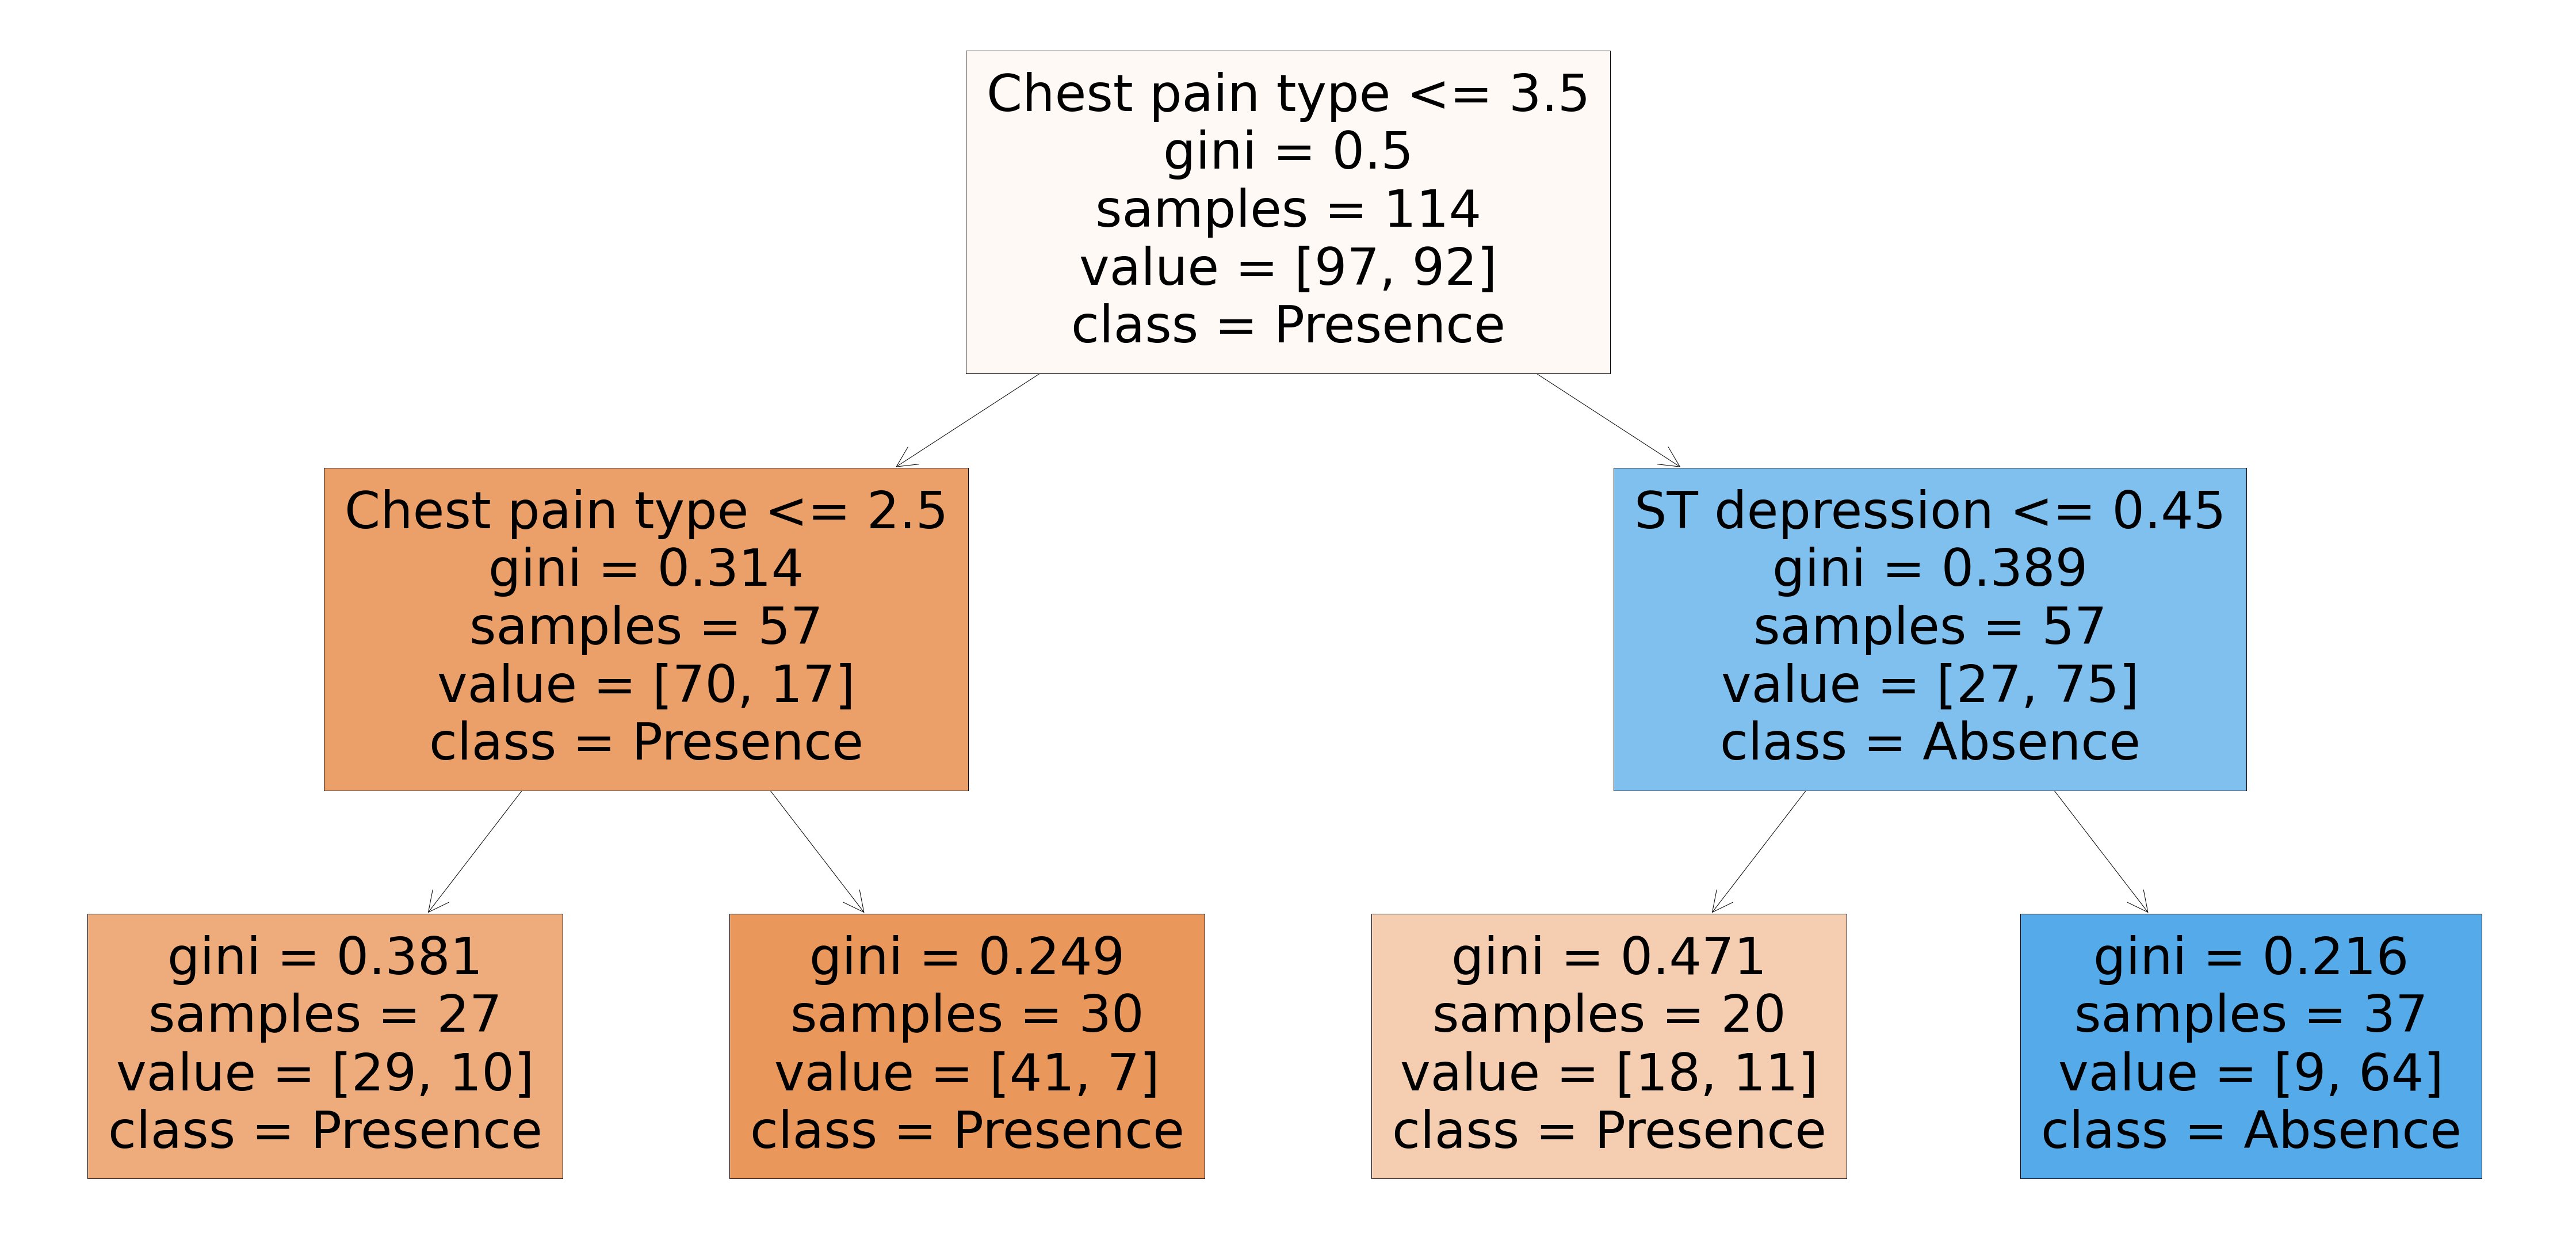

In [66]:
from sklearn.tree import plot_tree
plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[5], feature_names = X.columns,class_names=['Presence', "Absence"],filled=True);

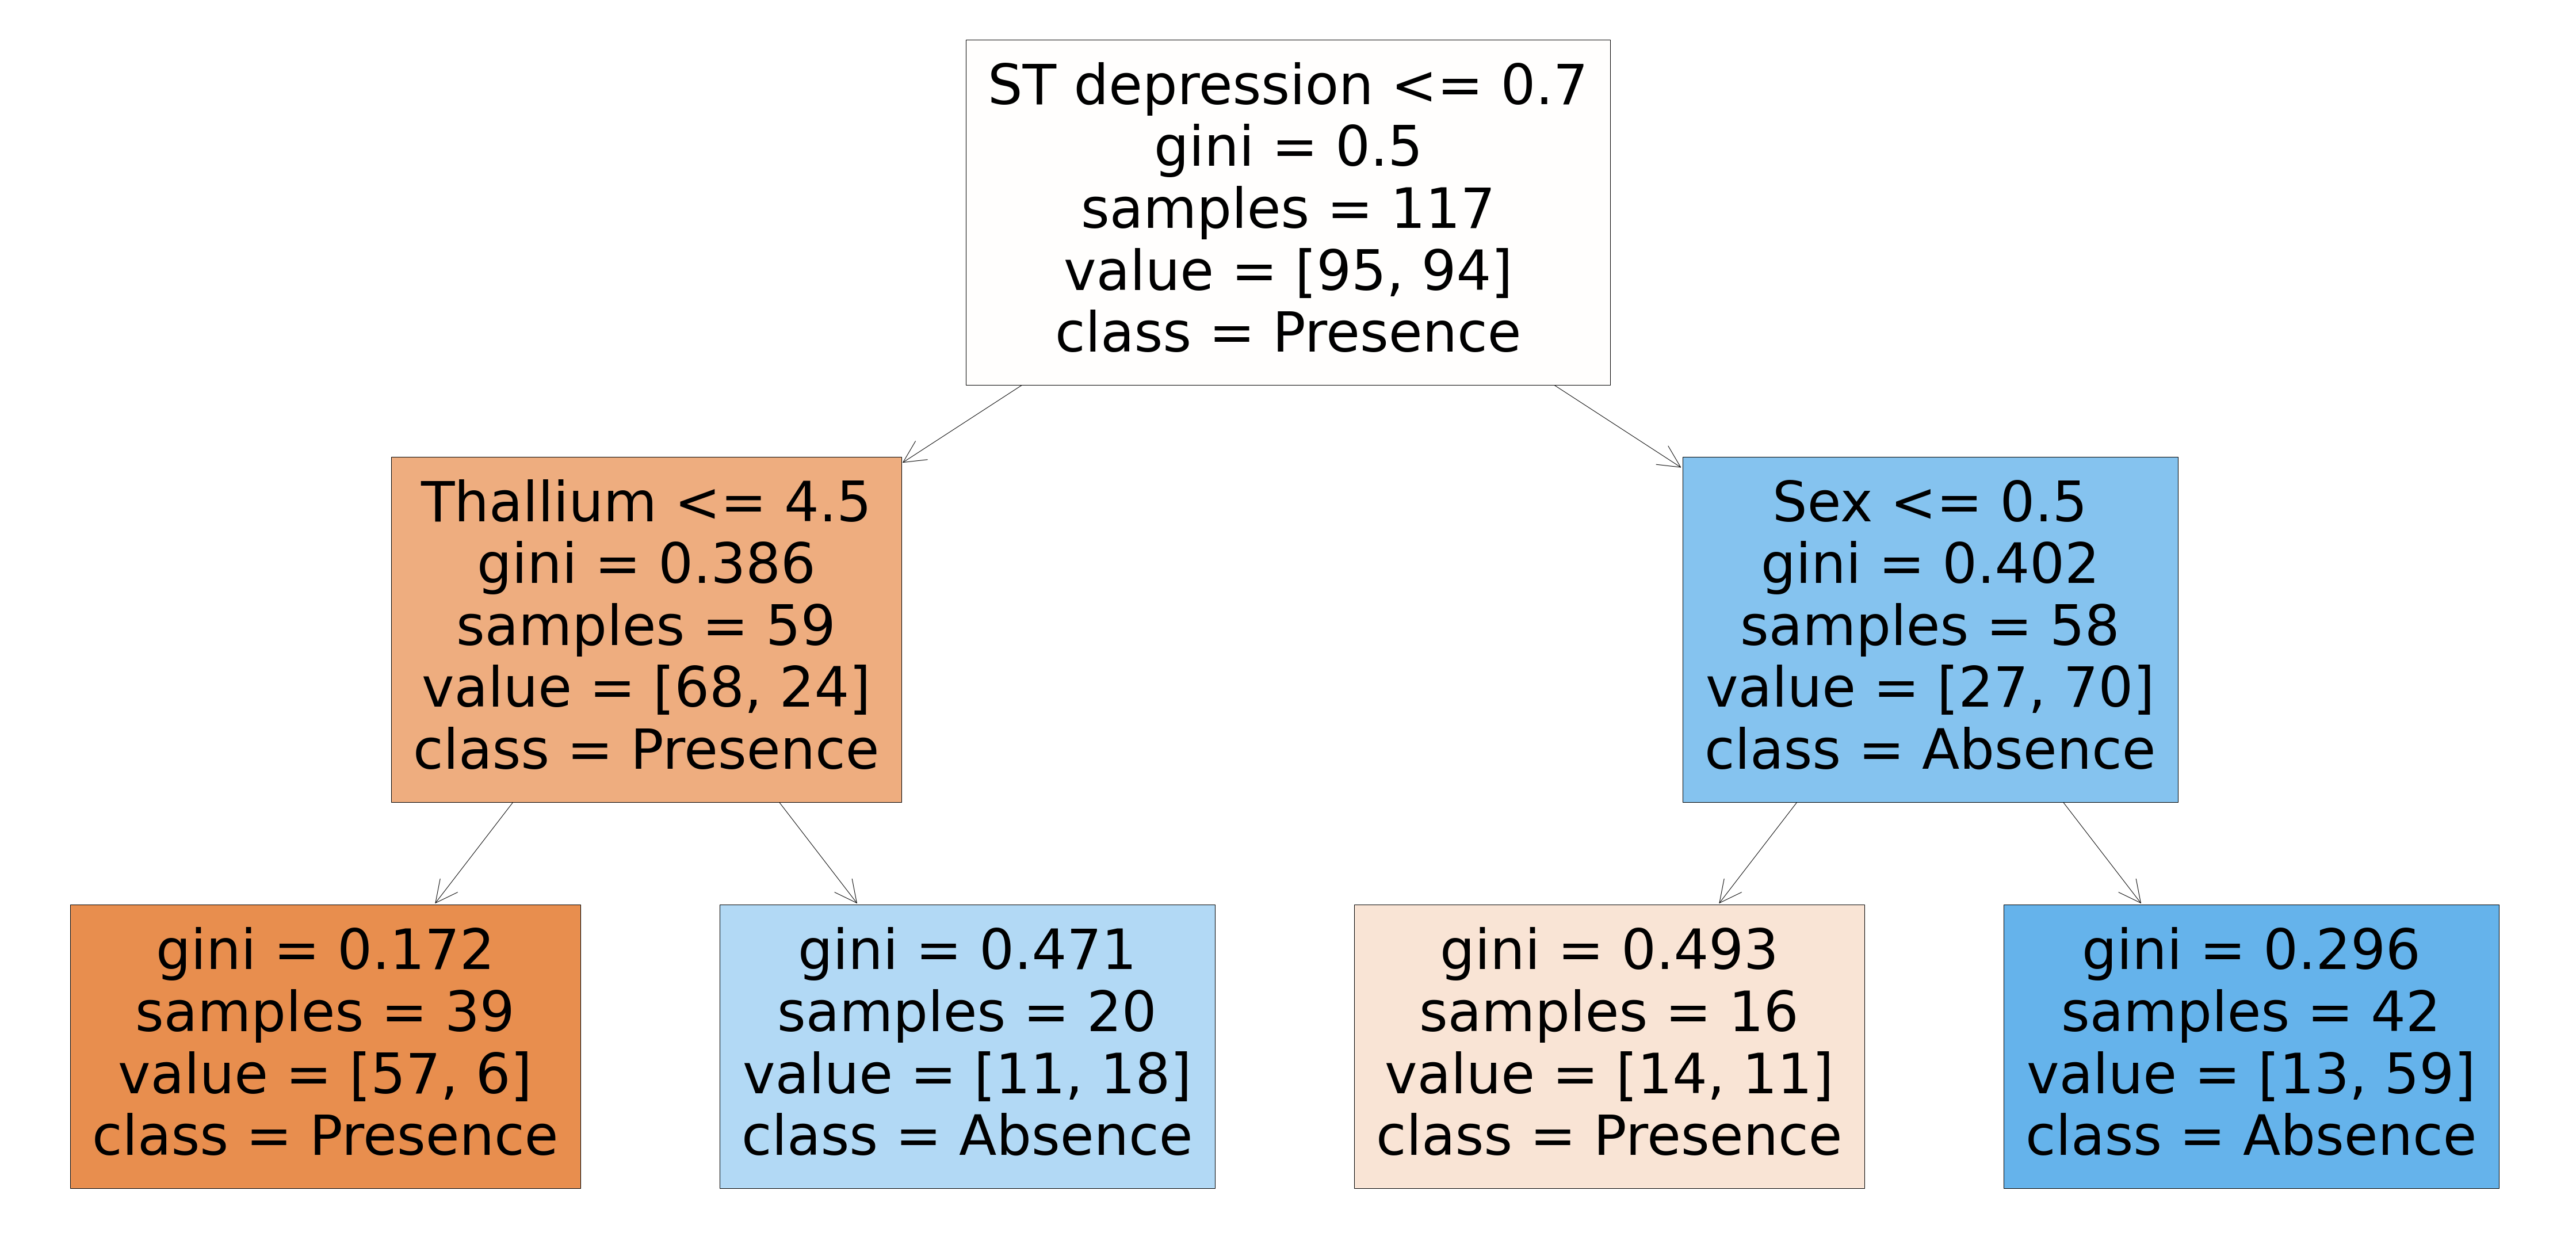

In [67]:
plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[9], feature_names = X.columns,class_names=['Presence', "Absence"],filled=True);

The trees created by estimators_[5] and estimators_[7] are different. Thus we can say that each tree is independent of the other.

Now let’s sort the data with the help of feature importance

In [68]:
rf_best.feature_importances_

array([0.00776444, 0.01296636, 0.19263076, 0.02482195, 0.00700454,
       0.        , 0.        , 0.09578406, 0.11539635, 0.14611145,
       0.12598692, 0.11430243, 0.15723074])

In [69]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})
imp_df.sort_values(by="Imp", ascending=False)

Varname       Imp
2           Chest pain type  0.192631
12                 Thallium  0.157231
9             ST depression  0.146111
10              Slope of ST  0.125987
8           Exercise angina  0.115396
11  Number of vessels fluro  0.114302
7                    Max HR  0.095784
3                        BP  0.024822
1                       Sex  0.012966
0                       Age  0.007764
4               Cholesterol  0.007005
5              FBS over 120  0.000000
6               EKG results  0.000000

In [72]:
y_pred_best_model = rf_best.predict(X_test)

In [76]:
y_test.shape

(81,)

In [77]:
y_test.value_counts()

0    49
1    32
Name: Heart Disease, dtype: int64

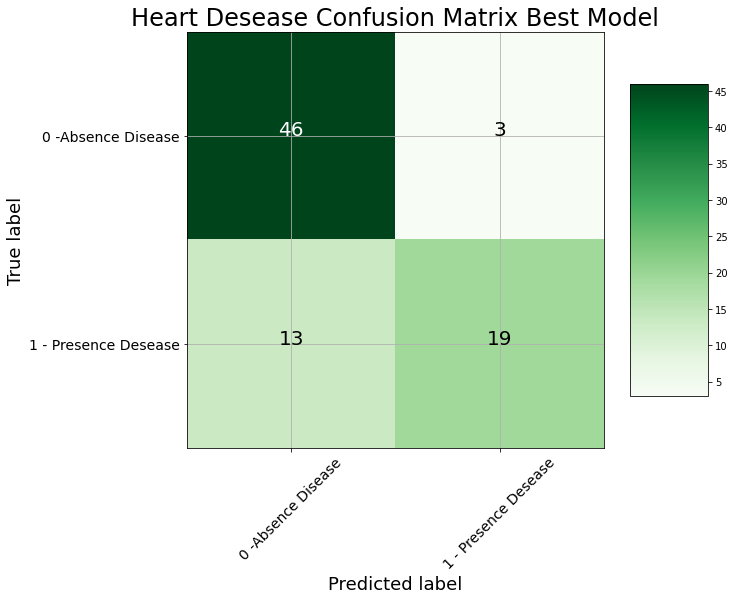

In [74]:
# Plot Confusion matrix
plot_confusion_matrix(confusion_matrix(y_test, y_pred_best_model), classes = ['0 -Absence Disease', '1 - Presence Desease'],
title = 'Heart Desease Confusion Matrix Best Model')

In [75]:
print(classification_report(y_test,y_pred_best_model))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85        49
           1       0.86      0.59      0.70        32

    accuracy                           0.80        81
   macro avg       0.82      0.77      0.78        81
weighted avg       0.81      0.80      0.79        81



# The model was much better predicting the 0-Absence Disease with a score og 0.85 than 1-Presence Disease 0.85

In [167]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [168]:
# Load IRIS data set
#
iris = datasets.load_iris()
X = iris.data[:, 2:]
y = iris.target
 

In [190]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [169]:
X

array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.7, 0.4],
       [1.4, 0.3],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.5, 0.1],
       [1.5, 0.2],
       [1.6, 0.2],
       [1.4, 0.1],
       [1.1, 0.1],
       [1.2, 0.2],
       [1.5, 0.4],
       [1.3, 0.4],
       [1.4, 0.3],
       [1.7, 0.3],
       [1.5, 0.3],
       [1.7, 0.2],
       [1.5, 0.4],
       [1. , 0.2],
       [1.7, 0.5],
       [1.9, 0.2],
       [1.6, 0.2],
       [1.6, 0.4],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.6, 0.2],
       [1.6, 0.2],
       [1.5, 0.4],
       [1.5, 0.1],
       [1.4, 0.2],
       [1.5, 0.2],
       [1.2, 0.2],
       [1.3, 0.2],
       [1.4, 0.1],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.3, 0.3],
       [1.3, 0.3],
       [1.3, 0.2],
       [1.6, 0.6],
       [1.9, 0.4],
       [1.4, 0.3],
       [1.6, 0.2],
       [1.4, 0.2],
       [1.5, 0.2],
       [1.4, 0.2],
       [4.7, 1.4],
       [4.5, 1.5],
       [4.9,

In [189]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [171]:
# Create an instance of Random Forest Classifier
forest = RandomForestClassifier(criterion='gini',
                                 n_estimators=5,
                                 random_state=1,
                                 n_jobs=2)

In [172]:
# Fit the model
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, n_jobs=2, random_state=1)

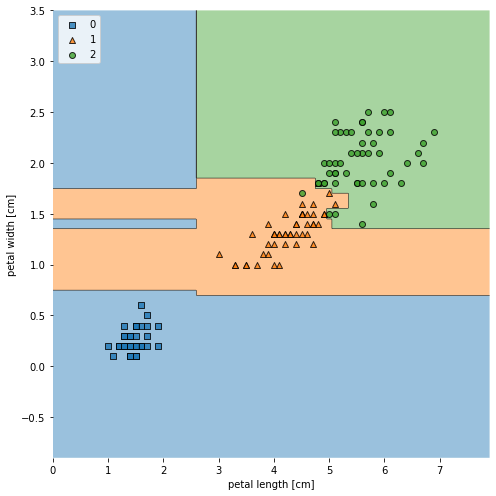

In [173]:
from mlxtend.plotting import plot_decision_regions
 
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
 
#
# plot_decision_regions function takes "forest" as classifier
#
fig, ax = plt.subplots(figsize=(7, 7))
plot_decision_regions(X_combined, y_combined, clf=forest)
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [174]:
y_pred = forest.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.978


# Random Forest Classifier – Python Code Example using GridSearch

In [177]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [178]:
from sklearn.model_selection import GridSearchCV

In [179]:
# Create an instance of Random Forest Classifier
#
forest = RandomForestClassifier()

In [180]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=forest,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [185]:
rf_best = grid_search.fit(X_train, y_train)
rf_best

Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [186]:
rf_best.best_estimator_

RandomForestClassifier(max_depth=2, min_samples_leaf=10, n_estimators=25)

In [187]:
y_pred_best_model = rf_best.predict(X_test)

In [188]:
print(classification_report(y_test,y_pred_best_model))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



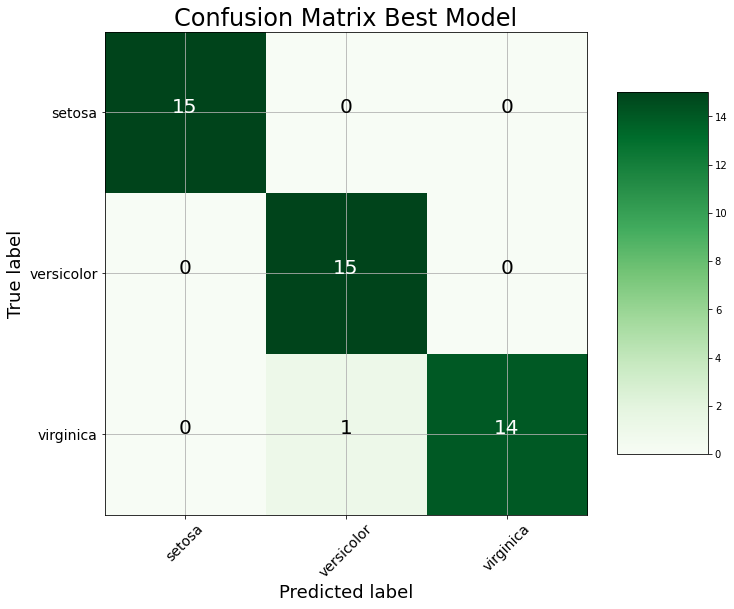

In [191]:
# Plot Confusion matrix
plot_confusion_matrix(confusion_matrix(y_test, y_pred_best_model), classes = ['setosa', 'versicolor', 'virginica'],
title = 'Confusion Matrix Best Model')

In [192]:
print('*************** Evaluation on Training Data ***************')
score_tr = rf_best.score(X_train, y_train)
print('Accuracy Score: ', score_tr)

*************** Evaluation on Training Data ***************
Accuracy Score:  0.9714285714285714


In [193]:
print('*************** Evaluation on Test Data ***************')
score_tr = rf_best.score(X_test, y_test)
print('Accuracy Score: ', score_tr)

*************** Evaluation on Test Data ***************
Accuracy Score:  0.9777777777777777


# Randome Forest Regressor

In [205]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [207]:
dataset = pd.read_csv('C:/Users/Admin/Machine Learning chapter 5/Position_Salaries.csv')
dataset

Position  Level   Salary
0   Business Analyst      1    45000
1  Junior Consultant      2    50000
2  Senior Consultant      3    60000
3            Manager      4    80000
4    Country Manager      5   110000
5     Region Manager      6   150000
6            Partner      7   200000
7     Senior Partner      8   300000
8            C-level      9   500000
9                CEO     10  1000000

In [208]:
X = dataset.iloc[:,1:-1].values
y = dataset.iloc[:, -1].values

In [209]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(random_state=0,n_estimators=10)
regressor.fit(X,y)
#random_state is the seed value, just to make sure we both get same results.
#n_estimators defines the number of trees you want to implement

RandomForestRegressor(n_estimators=10, random_state=0)

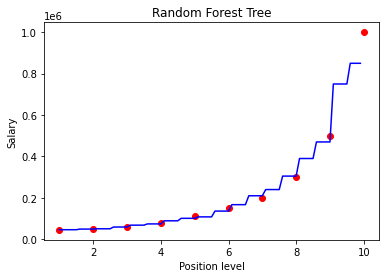

In [210]:
X_grid = np.arange(min(X), max(X), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid,regressor.predict(X_grid), color = 'blue')
plt.title('Random Forest Tree')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

In [211]:
print(regressor.predict([[6.5]]))
# predict method expects a 2D array thats the reason you see [[6.5]]

[167000.]


In [237]:
# Pandas is used for data manipulation
import pandas as pd
# Read in data and display first 5 rows
features = pd.read_csv('C:/Users/Admin/Machine Learning chapter 5/temperatureSecond..csv')
features.head(5)

year  month  day  week  temp_2  temp_1  average  actual  forecast_noaa  \
0  2016      1    1   Fri      45      45     45.6      45             43   
1  2016      1    2   Sat      44      45     45.7      44             41   
2  2016      1    3   Sun      45      44     45.8      41             43   
3  2016      1    4   Mon      44      41     45.9      40             44   
4  2016      1    5  Tues      41      40     46.0      44             46   

   forecast_acc  forecast_under  friend  
0            50              44      29  
1            50              44      61  
2            46              47      56  
3            48              46      53  
4            46              46      41

In [238]:
print('The shape of our features is:', features.shape)

The shape of our features is: (348, 12)


In [239]:
# Descriptive statistics for each column
features.describe()

year       month         day      temp_2      temp_1     average  \
count   348.0  348.000000  348.000000  348.000000  348.000000  348.000000   
mean   2016.0    6.477011   15.514368   62.652299   62.701149   59.760632   
std       0.0    3.498380    8.772982   12.165398   12.120542   10.527306   
min    2016.0    1.000000    1.000000   35.000000   35.000000   45.100000   
25%    2016.0    3.000000    8.000000   54.000000   54.000000   49.975000   
50%    2016.0    6.000000   15.000000   62.500000   62.500000   58.200000   
75%    2016.0   10.000000   23.000000   71.000000   71.000000   69.025000   
max    2016.0   12.000000   31.000000  117.000000  117.000000   77.400000   

           actual  forecast_noaa  forecast_acc  forecast_under      friend  
count  348.000000     348.000000    348.000000      348.000000  348.000000  
mean    62.543103      57.238506     62.373563       59.772989   60.034483  
std     11.794146      10.605746     10.549381       10.705256   15.626179  
min     35.000000      41.000000     46.000000       44.000000   28.000000  
25%     54.000000      48.000000     53.000000       50.000000   47.750000  
50%     62.500000      56.000000     61.000000       58.000000   60.000000  
75%     71.000000      66.000000     72.000000       69.000000   71.000000  
max     92.000000      77.000000     82.000000       79.000000   95.000000

In [240]:
# One-hot encode the data using pandas get_dummies
features = pd.get_dummies(features)
features

year  month  day  temp_2  temp_1  average  actual  forecast_noaa  \
0    2016      1    1      45      45     45.6      45             43   
1    2016      1    2      44      45     45.7      44             41   
2    2016      1    3      45      44     45.8      41             43   
3    2016      1    4      44      41     45.9      40             44   
4    2016      1    5      41      40     46.0      44             46   
..    ...    ...  ...     ...     ...      ...     ...            ...   
343  2016     12   27      42      42     45.2      47             41   
344  2016     12   28      42      47     45.3      48             41   
345  2016     12   29      47      48     45.3      48             43   
346  2016     12   30      48      48     45.4      57             44   
347  2016     12   31      48      57     45.5      40             42   

     forecast_acc  forecast_under  friend  week_Fri  week_Mon  week_Sat  \
0              50              44      29         1         0         0   
1              50              44      61         0         0         1   
2              46              47      56         0         0         0   
3              48              46      53         0         1         0   
4              46              46      41         0         0         0   
..            ...             ...     ...       ...       ...       ...   
343            50              47      47         0         0         0   
344            49              44      58         0         0         0   
345            50              45      65         0         0         0   
346            46              44      42         1         0         0   
347            48              47      57         0         0         1   

     week_Sun  week_Thurs  week_Tues  week_Wed  
0           0           0          0         0  
1           0           0          0         0  
2           1           0          0         0  
3           0           0          0         0  
4           0           0          1         0  
..        ...         ...        ...       ...  
343         0           0          1         0  
344         0           0          0         1  
345         0           1          0         0  
346         0           0          0         0  
347         0           0          0         0  

[348 rows x 18 columns]

In [241]:
features.shape

(348, 18)

In [242]:
# Display the first 5 rows of the last 12 columns
features.iloc[:,11:18].head(5)

week_Fri  week_Mon  week_Sat  week_Sun  week_Thurs  week_Tues  week_Wed
0         1         0         0         0           0          0         0
1         0         0         1         0           0          0         0
2         0         0         0         1           0          0         0
3         0         1         0         0           0          0         0
4         0         0         0         0           0          1         0

In [243]:
# Use numpy to convert to arrays
import numpy as np

In [244]:
# Labels are the values we want to predict
labels = np.array(features['actual'])
labels

array([45, 44, 41, 40, 44, 51, 45, 48, 50, 52, 45, 49, 55, 49, 48, 54, 50,
       54, 48, 52, 52, 57, 48, 51, 54, 56, 57, 56, 52, 48, 47, 46, 51, 49,
       49, 53, 49, 51, 57, 62, 56, 55, 58, 55, 56, 57, 53, 51, 53, 51, 51,
       60, 59, 61, 60, 57, 53, 58, 55, 59, 57, 64, 60, 53, 54, 55, 56, 55,
       52, 54, 49, 51, 53, 58, 63, 61, 55, 56, 57, 53, 54, 57, 59, 51, 56,
       64, 68, 73, 71, 63, 69, 60, 57, 68, 77, 76, 66, 59, 58, 60, 59, 59,
       60, 68, 77, 89, 81, 81, 73, 64, 65, 55, 59, 60, 61, 64, 61, 68, 77,
       87, 74, 60, 68, 77, 82, 63, 67, 75, 81, 77, 82, 65, 57, 60, 71, 64,
       63, 66, 59, 66, 65, 66, 66, 65, 64, 64, 64, 71, 79, 75, 71, 80, 81,
       92, 86, 85, 67, 65, 67, 65, 70, 66, 60, 67, 71, 67, 65, 70, 76, 73,
       75, 68, 69, 71, 78, 85, 79, 74, 73, 76, 76, 71, 68, 69, 76, 68, 74,
       71, 74, 74, 77, 75, 77, 76, 72, 80, 73, 78, 82, 81, 71, 75, 80, 85,
       79, 83, 85, 88, 76, 73, 77, 73, 75, 80, 79, 72, 72, 73, 72, 76, 80,
       87, 90, 83, 84, 81

In [245]:
# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('actual', axis = 1)

In [246]:
# Saving feature names for later use
feature_list = list(features.columns)

In [247]:
feature_list

['year',
 'month',
 'day',
 'temp_2',
 'temp_1',
 'average',
 'forecast_noaa',
 'forecast_acc',
 'forecast_under',
 'friend',
 'week_Fri',
 'week_Mon',
 'week_Sat',
 'week_Sun',
 'week_Thurs',
 'week_Tues',
 'week_Wed']

In [248]:
features.shape

(348, 17)

In [249]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

In [250]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [251]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (261, 17)
Training Labels Shape: (261,)
Testing Features Shape: (87, 17)
Testing Labels Shape: (87,)


In [252]:
test_labels

array([66, 61, 52, 66, 70, 82, 85, 84, 65, 92, 61, 85, 44, 65, 69, 62, 64,
       56, 53, 79, 63, 57, 67, 62, 59, 56, 65, 52, 66, 76, 64, 61, 48, 81,
       77, 57, 58, 47, 68, 51, 77, 56, 73, 51, 59, 87, 58, 81, 58, 42, 49,
       40, 65, 64, 70, 65, 53, 57, 53, 60, 67, 49, 53, 69, 55, 68, 76, 69,
       78, 36, 74, 57, 69, 50, 56, 67, 48, 80, 48, 49, 57, 77, 81, 67, 66,
       57, 45], dtype=int64)

In [256]:
test_features

year  month  day  temp_2  temp_1  average  forecast_noaa  forecast_acc  \
255  2016      9   29      69      68     66.1             63            71   
114  2016      4   27      59      60     60.7             59            65   
314  2016     11   28      53      48     48.0             46            48   
268  2016     10   12      60      62     61.0             60            63   
167  2016      6   19      67      65     70.4             69            73   
..    ...    ...  ...     ...     ...      ...            ...           ...   
152  2016      6    4      71      80     67.9             63            72   
165  2016      6   17      67      71     70.0             66            74   
261  2016     10    5      61      63     63.7             61            66   
60   2016      3    4      55      59     51.9             47            56   
338  2016     12   22      51      49     45.1             42            47   

     forecast_under  friend  week_Fri  week_Mon  week_Sat  week_Sun  \
255              68      57         0         0         0         0   
114              60      50         0         0         0         0   
314              49      44         0         1         0         0   
268              63      52         0         0         0         0   
167              70      58         0         0         0         1   
..              ...     ...       ...       ...       ...       ...   
152              66      76         0         0         1         0   
165              69      54         1         0         0         0   
261              65      48         0         0         0         0   
60               53      45         1         0         0         0   
338              46      38         0         0         0         0   

     week_Thurs  week_Tues  week_Wed  
255           1          0         0  
114           0          0         1  
314           0          0         0  
268           0          0         1  
167           0          0         0  
..          ...        ...       ...  
152           0          0         0  
165           0          0         0  
261           0          0         1  
60            0          0         0  
338           1          0         0  

[87 rows x 17 columns]

In [257]:
# The baseline predictions are the historical averages
baseline_preds = test_features.iloc[:,5]
baseline_preds

255    66.1
114    60.7
314    48.0
268    61.0
167    70.4
       ... 
152    67.9
165    70.0
261    63.7
60     51.9
338    45.1
Name: average, Length: 87, dtype: float64

In [258]:
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
baseline_errors

255     0.1
114     0.3
314     4.0
268     5.0
167     0.4
       ... 
152    13.1
165     3.0
261     2.3
60      5.1
338     0.1
Name: average, Length: 87, dtype: float64

In [259]:
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  5.06


The baseline prediction for our case can be the historical max temperature averages. In other words, our baseline is the error we would get if we simply predicted the average max temperature for all days.

In [260]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

In [261]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [262]:
#Train the model on training data
rf.fit(train_features, train_labels);

In [263]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

In [264]:
# Calculate the absolute errors
errors = abs(predictions - test_labels)

In [265]:
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 3.87 degrees.


Our average estimate is off by 3.83 degrees. That is more than a 1 degree average improvement over the baseline. Although this might not seem significant, it is nearly 25% better than the baseline, which, depending on the field and the problem, could represent millions of dollars to a company.

In [266]:
# Calculate mean absolute percentage error (MAPE). MAPE the lower the better for the model. 
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.93 %.


In [272]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [273]:
from sklearn.model_selection import GridSearchCV

In [274]:
# Create an instance of Random Forest Classifier
forest = RandomForestClassifier()

In [275]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=forest,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [276]:
rf_best = grid_search.fit(train_features, train_labels)
rf_best

Fitting 4 folds for each of 180 candidates, totalling 720 fits


C:\Users\Admin\anacondalastone\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=4.



GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [277]:
rf_best.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=30)

In [279]:
y_pred_best_regression = rf_best.predict(test_features)

In [282]:
# Calculate the absolute errors
errors_best_model = abs(y_pred_best_regression - test_labels)

In [283]:
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_best_model), 2), 'degrees.')

Mean Absolute Error: 4.68 degrees.


In [284]:
# Calculate mean absolute percentage error (MAPE). MAPE the lower the better for the model. 
mape = 100 * (errors_best_model / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 92.55 %.


# the first model using n_estimators = 1000, gives better results rather than the grid search with n_ estimator to train: 'n_estimators': [10,25,30,50,100,200]. I thought it was going to be overfitted and not giving good results on the testing data due to the high number of estimator, this more complex model has better MAE and Accuracy score than the simpler grid search model. 

In [286]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In this first example, we will implement a multiclass classification model with a Random Forest classifier and Python's Scikit-Learn.

In [99]:
dataset = pd.read_csv('C:/Users/Admin/Machine Learning chapter 5/Maternal Health Risk Data Set.csv')

In [289]:
dataset

Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0      25         130           80  15.0      98.0         86  high risk
1      35         140           90  13.0      98.0         70  high risk
2      29          90           70   8.0     100.0         80  high risk
3      30         140           85   7.0      98.0         70  high risk
4      35         120           60   6.1      98.0         76   low risk
...   ...         ...          ...   ...       ...        ...        ...
1009   22         120           60  15.0      98.0         80  high risk
1010   55         120           90  18.0      98.0         60  high risk
1011   35          85           60  19.0      98.0         86  high risk
1012   43         120           90  18.0      98.0         70  high risk
1013   32         120           65   6.0     101.0         76   mid risk

[1014 rows x 7 columns]

In [290]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [291]:
dataset.describe().T # T transposes the table

count        mean        std   min    25%    50%    75%    max
Age          1014.0   29.871795  13.474386  10.0   19.0   26.0   39.0   70.0
SystolicBP   1014.0  113.198225  18.403913  70.0  100.0  120.0  120.0  160.0
DiastolicBP  1014.0   76.460552  13.885796  49.0   65.0   80.0   90.0  100.0
BS           1014.0    8.725986   3.293532   6.0    6.9    7.5    8.0   19.0
BodyTemp     1014.0   98.665089   1.371384  98.0   98.0   98.0   98.0  103.0
HeartRate    1014.0   74.301775   8.088702   7.0   70.0   76.0   80.0   90.0

Also, because we are using trees and that the resulting class will be obtained by voting, we aren't inherently comparing between different values, only between the same types of values, so adjusting the features to the same scale isn't necessary in this case. This means that the Random Forest classification model is scale invariant, and you don't need to perform feature scaling.

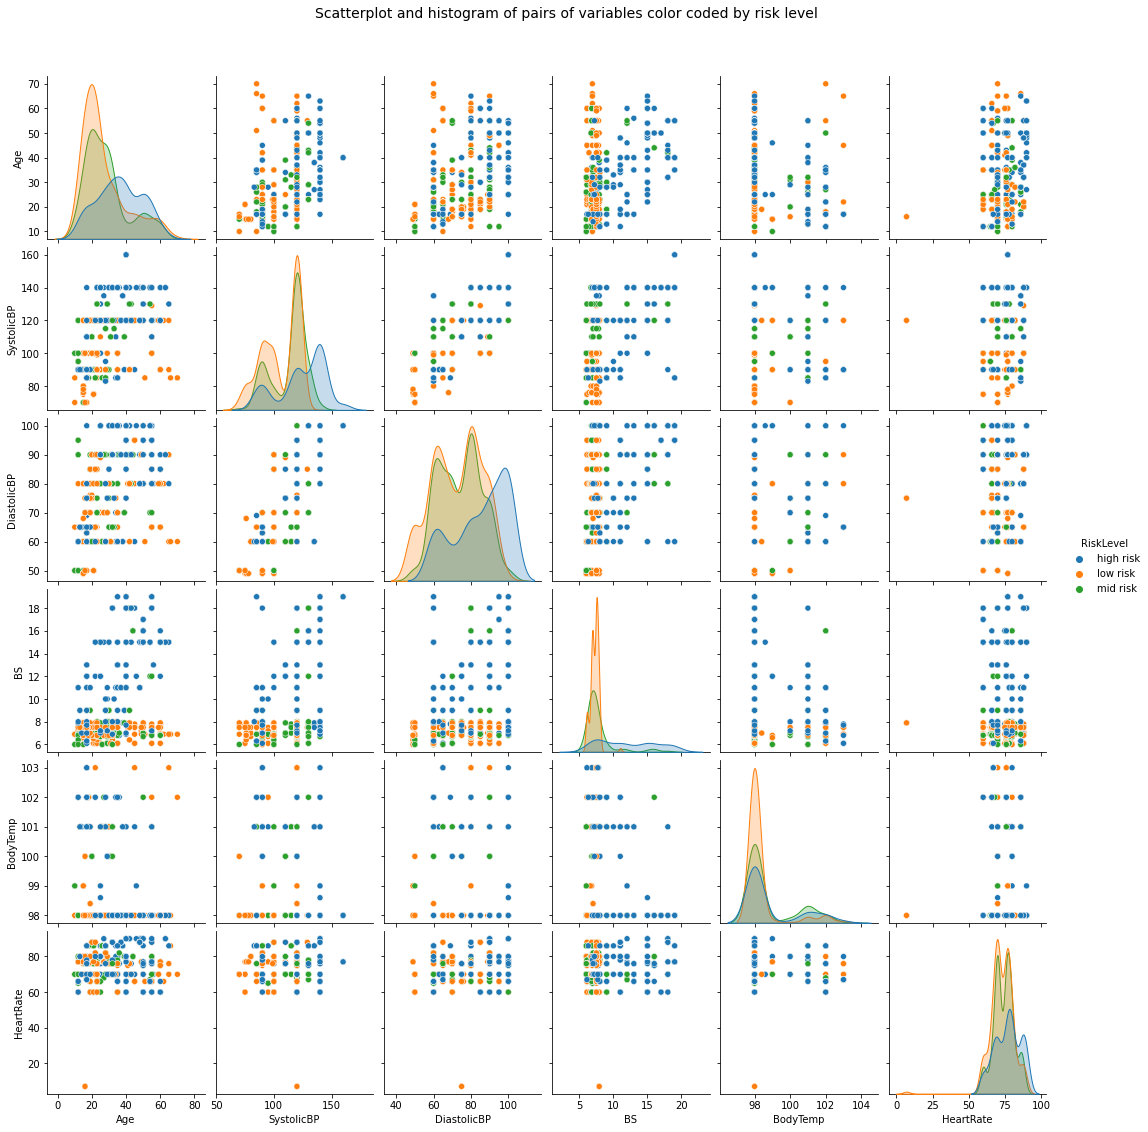

In [292]:
g = sns.pairplot(dataset, hue='RiskLevel')
g.fig.suptitle("Scatterplot and histogram of pairs of variables color coded by risk level", 
               fontsize = 14, # defining the size of the title
               y=1.05); # y = defining title y position (height)

 As we can see, the three types of risk classes are mostly mixed up, since trees internally draw lines when delimiting the spaces between points, we can hypothesize that more trees in the forest might be able to limit more spaces and better classify the points.

In [293]:
dataset['RiskLevel'].unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

In [294]:
dataset['RiskLevel'] = dataset['RiskLevel'].replace('low risk', 0).replace('mid risk', 1).replace('high risk', 2)

In [295]:
y = dataset['RiskLevel']
X = dataset.drop(['RiskLevel'], axis=1)

In [296]:
from sklearn.model_selection import train_test_split

SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=SEED)

Advice: remember to use a random state seed if you want to make the result reproducible. We've used a random state seed so you can reproduce the same results as from the guide

In [297]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=3, 
                             max_depth=2,
                             random_state=SEED)

Note: The default value for n_estimators is 100. This boosts the predictive power and generalization of the ensemble, but we're creating a smaller one to make it easier to visualize and inspect it. With just 3 trees - we can visualize and inspect them manually to further build our intuition of both the individual trees, and their co-dependence. The same applies for max_depth, which is None,default,meaning the trees can get deeper and deeper to fit the data as required.

In [298]:
# Fit RandomForestClassifier
Model = rfc.fit(X_train, y_train)
# Predict the test set labels
y_pred = Model.predict(X_test)

DecisionTreeClassifier(max_depth=2, max_features='sqrt',
                       random_state=1608637542)


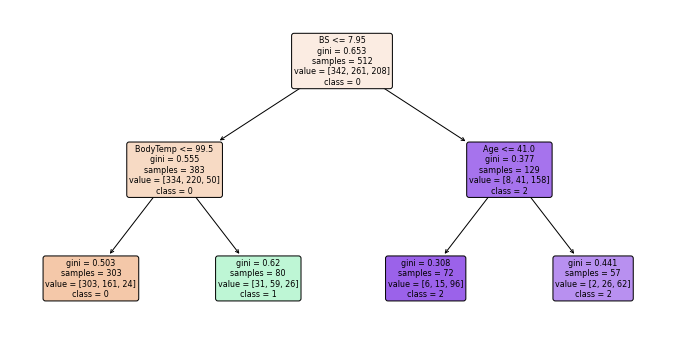

DecisionTreeClassifier(max_depth=2, max_features='sqrt',
                       random_state=1273642419)


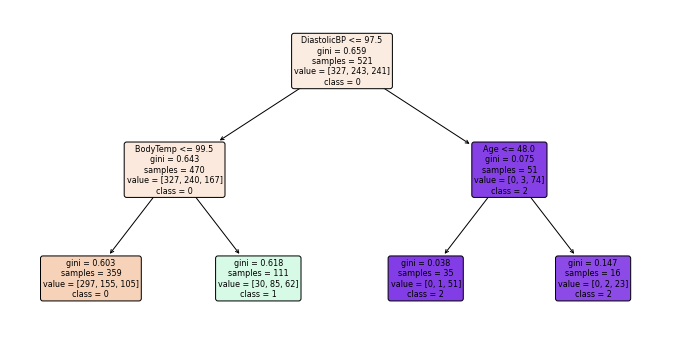

DecisionTreeClassifier(max_depth=2, max_features='sqrt',
                       random_state=1935803228)


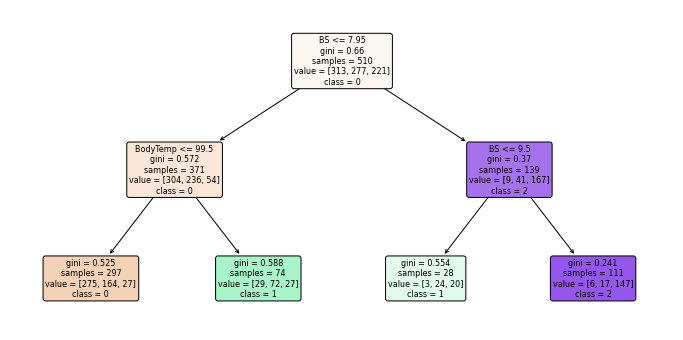

In [299]:
# Import `tree` module
from sklearn import tree

features = X.columns.values # The name of each column
classes = ['0', '1', '2'] # The name of each class
# You can also use low, medium and high risks in the same order instead
# classes = ['low risk', 'medium risk', 'high risk']

for estimator in rfc.estimators_:
    print(estimator)
    plt.figure(figsize=(12,6))
    tree.plot_tree(estimator,
                   feature_names=features,
                   class_names=classes,
                   fontsize=8, 
                   filled=True, 
                   rounded=True)
    plt.show()

you see three beacause the model has three trees. 

The more trees in the forest, the more diverse the model can be. There's a point of diminishing returns, though, as with many trees fit on a random subset of features, there will be a fair bit of similar trees that don't offer much diversity in the ensemble, and which will start to have too much voting power and skew the ensemble to be overfit on the training dataset, hurting generalization to the validation set.

              precision    recall  f1-score   support

           0       0.53      0.89      0.66        80
           1       0.57      0.17      0.26        76
           2       0.74      0.72      0.73        47

    accuracy                           0.58       203
   macro avg       0.61      0.59      0.55       203
weighted avg       0.59      0.58      0.53       203



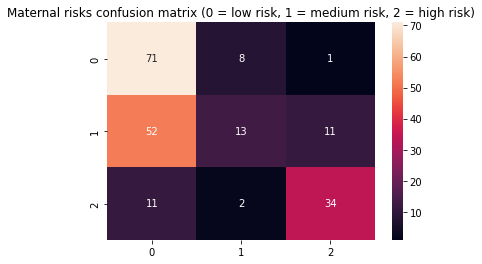

In [300]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('Maternal risks confusion matrix (0 = low risk, 1 = medium risk, 2 = high risk)')

print(classification_report(y_test,y_pred))

The model is having a very hard time when identifying the medium risk cases.

Another thing that can be checked to generate even more insight is what features are most taken into consideration by the classifier when predicting. 

In [301]:
# Organizing feature names and importances in a DataFrame
features_df = pd.DataFrame({'features': rfc.feature_names_in_, 'importances': rfc.feature_importances_ })
features_df 

features  importances
0          Age     0.005969
1   SystolicBP     0.000000
2  DiastolicBP     0.226633
3           BS     0.573164
4     BodyTemp     0.194234
5    HeartRate     0.000000

In [302]:
# Sorting data from highest to lowest
features_df_sorted = features_df.sort_values(by='importances', ascending=False)
features_df_sorted

features  importances
3           BS     0.573164
2  DiastolicBP     0.226633
4     BodyTemp     0.194234
0          Age     0.005969
1   SystolicBP     0.000000
5    HeartRate     0.000000

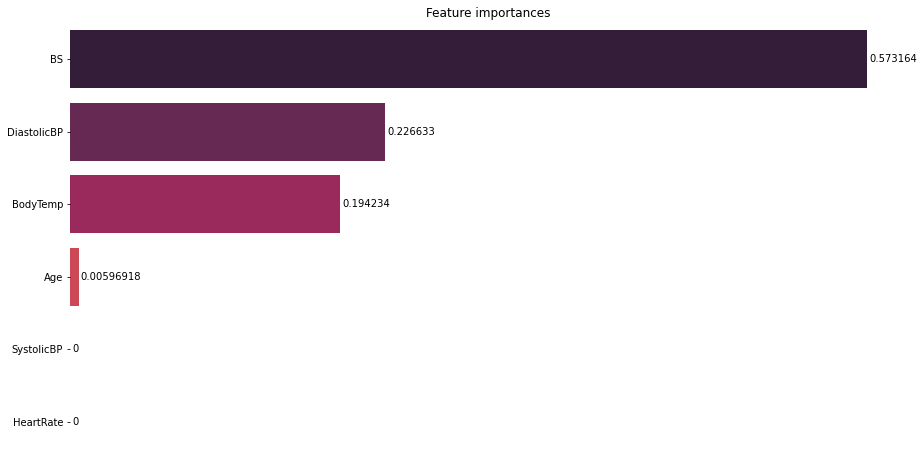

In [304]:
# Barplot of the result without borders and axis lines
plt.figure(figsize=(15,8))
g = sns.barplot(data=features_df_sorted, x='importances', y ='features', palette="rocket")
sns.despine(bottom = True, left = True)
g.set_title('Feature importances')
g.set(xlabel=None)
g.set(ylabel=None)
g.set(xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

Notice how the classifier is mostly considering the blood sugar, then a little of the diastolic pressure, body temperature and just a little of age to make a decision, this might also have to do with the low recall on class 1, maybe the medium risk data has to do with features that are not being taken into much consideration by the model. You can try to play around more with feature importances to investigate this, and see if changes on the model affect the features being used, also if there's a significant relationship between some of the features and the predicted classes.

In [305]:
rfc_ = RandomForestClassifier(n_estimators=900, 
                             max_depth=7,
                             random_state=SEED)

In [306]:
rfc_.fit(X_train, y_train)
y_pred = rfc_.predict(X_test)

              precision    recall  f1-score   support

           0       0.68      0.86      0.76        80
           1       0.75      0.58      0.65        76
           2       0.90      0.81      0.85        47

    accuracy                           0.74       203
   macro avg       0.78      0.75      0.75       203
weighted avg       0.76      0.74      0.74       203



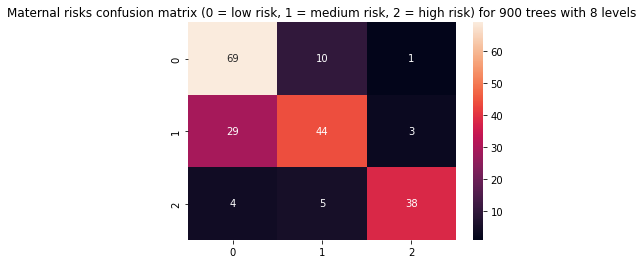

In [307]:
cm_ = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_, annot=True, fmt='d').set_title('Maternal risks confusion matrix (0 = low risk, 1 = medium risk, 2 = high risk) for 900 trees with 8 levels')

print(classification_report(y_test,y_pred))

This shows how adding more trees, and more specialized trees (higher levels), has improved our metrics. We still have a low recall for class 1, but the accuracy is now 74%. The F1-score when classifying high risk cases is 0.85, which means high risk cases are now more easily identified when compared to 0.73 in the previous model!

In [309]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200,400,600,900,1000]
}

In [310]:
from sklearn.model_selection import GridSearchCV

In [311]:
# Create an instance of Random Forest Classifier
forest = RandomForestClassifier()

In [312]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=forest,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [314]:
rf_best = grid_search .fit(X_train, y_train)
rf_best

Fitting 4 folds for each of 300 candidates, totalling 1200 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200, 400, 600,
                                          900, 1000]},
             scoring='accuracy', verbose=1)

In [315]:
rf_best.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=30)

In [316]:
y_pred_best = rf_best.predict(X_test)

it did not improve the previous case. 

              precision    recall  f1-score   support

           0       0.68      0.84      0.75        80
           1       0.72      0.54      0.62        76
           2       0.83      0.83      0.83        47

    accuracy                           0.72       203
   macro avg       0.74      0.74      0.73       203
weighted avg       0.73      0.72      0.72       203



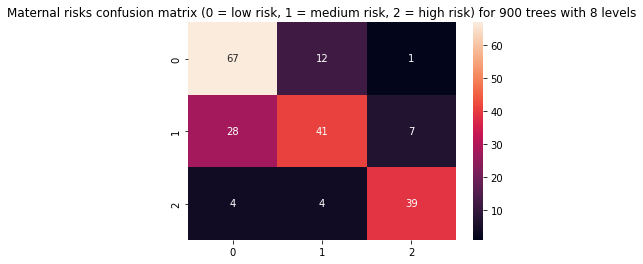

In [317]:
cm_ = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_, annot=True, fmt='d').set_title('Maternal risks confusion matrix (0 = low risk, 1 = medium risk, 2 = high risk) for 900 trees with 8 levels')

print(classification_report(y_test,y_pred_best))

In [319]:
# importing libraries  
import numpy as nm 

# Using Random Forests for Regression

Since regression is done for numerical values - let's pick a numerical value from the dataset. We've seen that blood sugar was important in the classification, so it should be predictable based on other features (since if it correlates with some feature, that feature also correlates with it).

In [100]:
dataset

Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0      25         130           80  15.0      98.0         86  high risk
1      35         140           90  13.0      98.0         70  high risk
2      29          90           70   8.0     100.0         80  high risk
3      30         140           85   7.0      98.0         70  high risk
4      35         120           60   6.1      98.0         76   low risk
...   ...         ...          ...   ...       ...        ...        ...
1009   22         120           60  15.0      98.0         80  high risk
1010   55         120           90  18.0      98.0         60  high risk
1011   35          85           60  19.0      98.0         86  high risk
1012   43         120           90  18.0      98.0         70  high risk
1013   32         120           65   6.0     101.0         76   mid risk

[1014 rows x 7 columns]

In [103]:
dataset['RiskLevel'] = dataset['RiskLevel'].replace('low risk', 0).replace('mid risk', 1).replace('high risk', 2)

In [104]:
from sklearn.model_selection import train_test_split

SEED = 42

y = dataset['BS']
X = dataset.drop(['BS'], axis=1) # You can either include risk level or drop it here

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=SEED)

In [105]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=20, # 20 trees
                            max_depth=3, # 4 levels
                            random_state=SEED)

rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

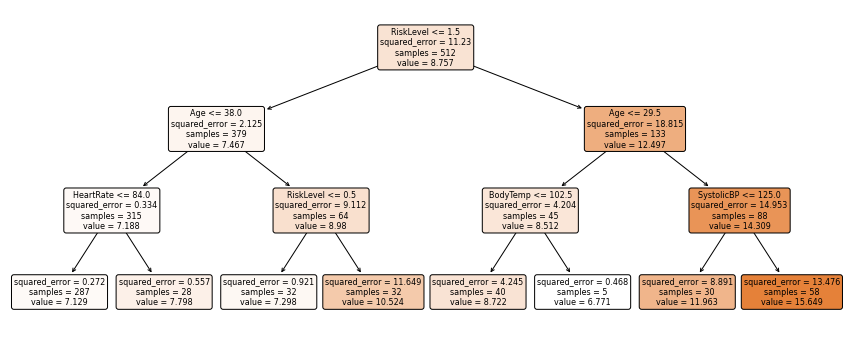

In [106]:
from sklearn import tree

features = X.columns
# Obtain just the first tree
first_tree = rfr.estimators_[0]

plt.figure(figsize=(15,6))
tree.plot_tree(first_tree,
               feature_names=features,
               fontsize=8, 
               filled=True, 
               rounded=True);

For regression problems the metrics used to evaluate an algorithm are mean absolute error (MAE), mean squared error (MSE), and root mean squared error (RMSE).

In [108]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('r2_score',r2_score(y_test, y_pred))

Mean Absolute Error: 1.127893702896059
Mean Squared Error: 3.0802988503933326
Root Mean Squared Error: 1.755078018320933
r2_score 0.6925082509660845


With 20 trees, the root mean squared error is 1.75 which is low, but even so - by raising the number of trees and experimenting with the other parameters, this error could probably get even smaller.

In [121]:
params = {'criterion' :['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,20,30,50,100,200,400,600,900,1000]
}

In [122]:
from sklearn.model_selection import GridSearchCV

In [123]:
# Create an instance of Random Forest Classifier
forest = RandomForestRegressor()

In [124]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=forest,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [125]:
rf_best_regressor = grid_search.fit(X_train, y_train)
rf_best_regressor

Fitting 4 folds for each of 1200 candidates, totalling 4800 fits


C:\Users\Admin\anacondalastone\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning:

One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]



GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'friedman_mse', 'poisson'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 20, 30, 50, 100, 200, 400, 600,
                                          900, 1000]},
             scoring='accuracy', verbose=1)

In [126]:
rf_best_regressor.best_estimator_

RandomForestRegressor(max_depth=2, min_samples_leaf=5, n_estimators=10)

In [127]:
y_pred = rf_best_regressor.predict(X_test)

In [128]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('r2_score',r2_score(y_test, y_pred))

Mean Absolute Error: 1.3178915101632815
Mean Squared Error: 4.232261216175242
Root Mean Squared Error: 2.057246027138038
r2_score 0.5775132651288188


# Again it gives a better result with the previous model. Not doing grid search. 

In [129]:
URL="https://raw.githubusercontent.com/aviralb13/codes/main/datas/Health_insurance.csv"
data=pd.read_csv(URL)
data.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [130]:
from sklearn import preprocessing
label = preprocessing.LabelEncoder()
data['sex'] = label.fit_transform(data['sex'])
data['smoker'] = label.fit_transform(data['smoker'])
data.head()

age  sex     bmi  children  smoker     region      charges
0   19    0  27.900         0       1  southwest  16884.92400
1   18    1  33.770         1       0  southeast   1725.55230
2   28    1  33.000         3       0  southeast   4449.46200
3   33    1  22.705         0       0  northwest  21984.47061
4   32    1  28.880         0       0  northwest   3866.85520

In [131]:
features=["age","sex","bmi","children","smoker"]
x = data[features]
y = data["charges"]

In [132]:
from sklearn.model_selection import train_test_split

train_x,test_x,train_y,test_y = train_test_split(x,y)

In [133]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(random_state = 0)
regressor.fit(train_x, train_y)

RandomForestRegressor(random_state=0)

In [134]:

prediction = regressor.predict(test_x)

In [135]:
regressor.predict([[19,0,27.900,0,1]])

C:\Users\Admin\anacondalastone\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



array([16981.59107])

In [138]:
data.head(1)

age  sex   bmi  children  smoker     region    charges
0   19    0  27.9         0       1  southwest  16884.924

In [139]:
print('Mean Absolute Error:', mean_absolute_error(test_y, prediction))
print('Mean Squared Error:', mean_squared_error(test_y, prediction))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(test_y, prediction)))
print('r2_score',r2_score(test_y, prediction))

Mean Absolute Error: 2959.8496968037816
Mean Squared Error: 27407437.63238296
Root Mean Squared Error: 5235.211326430191
r2_score 0.8312859152709942


# with the default values of sklearn we get an r2_score of 0.83. Really good accuracy. 

In [140]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,20,30,50,100,200,400,600,900,1000]
}

In [141]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=regressor,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [145]:
rf_best_regressor2 = grid_search.fit(train_x, train_y)
rf_best_regressor2

Fitting 4 folds for each of 300 candidates, totalling 1200 fits


C:\Users\Admin\anacondalastone\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 20, 30, 50, 100, 200, 400, 600,
                                          900, 1000]},
             scoring='accuracy', verbose=1)

In [146]:
rf_best_regressor2.best_estimator_

RandomForestRegressor(max_depth=2, min_samples_leaf=5, n_estimators=10,
                      random_state=0)

In [147]:
prediction = rf_best_regressor2.predict(test_x)

In [148]:
print('Mean Absolute Error:', mean_absolute_error(test_y, prediction))
print('Mean Squared Error:', mean_squared_error(test_y, prediction))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(test_y, prediction)))
print('r2_score',r2_score(test_y, prediction))

Mean Absolute Error: 3428.079639450356
Mean Squared Error: 28043602.20245663
Root Mean Squared Error: 5295.621040298922
r2_score 0.8273698277980746


# it gives a better results using the default values of sklearn parameters. 

and also, we can predict values from our dataset i.e. here I am predicting first 5 values from dataset.

In [149]:
regressor.predict(x[:5])

array([16981.59107  ,  4628.7343293,  5176.5889848, 14611.7842319,
        3864.6083735])

In [151]:
#actual values. 
data['charges'].head(5)

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

In [152]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [153]:
df = pd.read_csv('C:/Users/Admin/Machine Learning chapter 5/Classification Algorithms/games.csv')
df

id                type  \
0       12333           boardgame   
1      120677           boardgame   
2      102794           boardgame   
3       25613           boardgame   
4        3076           boardgame   
...       ...                 ...   
81307  184441  boardgameexpansion   
81308  184442           boardgame   
81309  184443           boardgame   
81310  184449           boardgame   
81311  184451           boardgame   

                                                    name  yearpublished  \
0                                      Twilight Struggle         2005.0   
1                                          Terra Mystica         2012.0   
2                              Caverna: The Cave Farmers         2013.0   
3              Through the Ages: A Story of Civilization         2006.0   
4                                            Puerto Rico         2002.0   
...                                                  ...            ...   
81307                               Micro Rome: Aegyptus         2015.0   
81308  Trivial Pursuit: Marvel Cinematic Universe  Da...         2013.0   
81309                                          BEARanoia         2015.0   
81310                                            Freight         2015.0   
81311                                  Bingo Animal Kids         2010.0   

       minplayers  maxplayers  playingtime  minplaytime  maxplaytime  minage  \
0             2.0         2.0        180.0        180.0        180.0    13.0   
1             2.0         5.0        150.0         60.0        150.0    12.0   
2             1.0         7.0        210.0         30.0        210.0    12.0   
3             2.0         4.0        240.0        240.0        240.0    12.0   
4             2.0         5.0        150.0         90.0        150.0    12.0   
...           ...         ...          ...          ...          ...     ...   
81307         1.0         1.0          0.0         30.0          0.0    10.0   
81308         2.0         0.0          0.0          0.0          0.0    12.0   
81309         2.0        15.0          1.0          1.0          1.0     0.0   
81310         2.0         4.0         60.0         30.0         60.0     8.0   
81311         1.0         6.0         10.0         10.0         10.0     2.0   

       users_rated  average_rating  bayes_average_rating  total_owners  \
0            20113         8.33774               8.22186         26647   
1            14383         8.28798               8.14232         16519   
2             9262         8.28994               8.06886         12230   
3            13294         8.20407               8.05804         14343   
4            39883         8.14261               8.04524         44362   
...            ...             ...                   ...           ...   
81307            0         0.00000               0.00000             0   
81308            0         0.00000               0.00000             0   
81309            0         0.00000               0.00000             0   
81310            0         0.00000               0.00000             0   
81311            0         0.00000               0.00000             0   

       total_traders  total_wanters  total_wishers  total_comments  \
0                372           1219           5865            5347   
1                132           1586           6277            2526   
2                 99           1476           5600            1700   
3                362           1084           5075            3378   
4                795            861           5414            9173   
...              ...            ...            ...             ...   
81307              0              0              0               0   
81308              0              0              0               0   
81309              0              0              0               0   
81310              0              0              0               0   
81311              0              0          

In [154]:
df.shape # Displays the shape of 'df'

(81312, 20)

In [155]:
df.columns # Displays column names of ‘df’.

Index(['id', 'type', 'name', 'yearpublished', 'minplayers', 'maxplayers',
       'playingtime', 'minplaytime', 'maxplaytime', 'minage', 'users_rated',
       'average_rating', 'bayes_average_rating', 'total_owners',
       'total_traders', 'total_wanters', 'total_wishers', 'total_comments',
       'total_weights', 'average_weight'],
      dtype='object')

In [156]:
df.nunique() # Displays total number of unique elements in each column.

id                      79463
type                        2
name                    76035
yearpublished             323
minplayers                 24
maxplayers                 89
playingtime               134
minplaytime               123
maxplaytime               134
minage                     35
users_rated              2147
average_rating          17564
bayes_average_rating    12681
total_owners             2995
total_traders             407
total_wanters             540
total_wishers            1130
total_comments           1216
total_weights             657
average_weight           3376
dtype: int64

In [158]:
df['type'].unique() # Prints the unique values in ‘type’ column

array(['boardgame', 'boardgameexpansion'], dtype=object)

In [159]:
df.describe() # Displays properties of each column

id  yearpublished    minplayers    maxplayers   playingtime  \
count   81312.000000   81309.000000  81309.000000  81309.000000  81309.000000   
mean    72278.150138    1806.630668      1.992018      5.637703     51.634788   
std     58818.237742     588.517834      0.931034     56.076890    345.699969   
min         1.000000   -3500.000000      0.000000      0.000000      0.000000   
25%     21339.750000    1984.000000      2.000000      2.000000      8.000000   
50%     43258.000000    2003.000000      2.000000      4.000000     30.000000   
75%    128836.500000    2010.000000      2.000000      6.000000     60.000000   
max    184451.000000    2018.000000     99.000000  11299.000000  60120.000000   

        minplaytime   maxplaytime        minage   users_rated  average_rating  \
count  81309.000000  81309.000000  81309.000000  81312.000000    81312.000000   
mean      49.276833     51.634788      6.983975    161.886585        4.212144   
std      334.483934    345.699969      5.035138   1145.978126        3.056551   
min        0.000000      0.000000      0.000000      0.000000        0.000000   
25%       10.000000      8.000000      0.000000      0.000000        0.000000   
50%       30.000000     30.000000      8.000000      2.000000        5.265620   
75%       60.000000     60.000000     12.000000     16.000000        6.718777   
max    60120.000000  60120.000000    120.000000  53680.000000       10.000000   

       bayes_average_rating  total_owners  total_traders  total_wanters  \
count          81312.000000  81312.000000   81312.000000   81312.000000   
mean               1.157632    262.502509       9.236423      12.688890   
std                2.340033   1504.536693      39.757408      60.764207   
min                0.000000      0.000000       0.000000       0.000000   
25%                0.000000      1.000000       0.000000       0.000000   
50%                0.000000      7.000000       0.000000       0.000000   
75%                0.000000     51.000000       2.000000       3.000000   
max                8.221860  73188.000000    1395.000000    1586.000000   

       total_wishers  total_comments  total_weights  average_weight  
count   81312.000000    81312.000000   81312.000000    81312.000000  
mean       42.719144       49.290031      16.488009        0.908083  
std       239.292628      284.862853     115.980285        1.176002  
min         0.000000        0.000000       0.000000        0.000000  
25%         0.000000        0.000000       0.000000        0.000000  
50%         1.000000        1.000000       0.000000        0.000000  
75%         7.000000        9.000000       2.000000        1.916700  
max      6402.000000    11798.000000    5996.000000        5.000000

(array([24380.,     0., 11306.,     0.,  6089.,     0.,  3970.,     0.,
         2818.,  2219.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

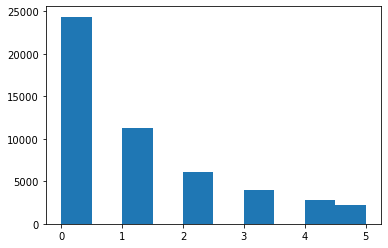

In [161]:
plt.hist(df['users_rated'],range = (0,5)) # Histogram of ‘users_rated’ column.

In [162]:

df[df['users_rated'] == 0]['average_rating'].describe() # Prints the properties of ‘average_rating’ column of board games which were not rated by any of the users.

count    24380.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: average_rating, dtype: float64

In [163]:
df[(df['maxplayers'] == 0) | (df['maxplaytime'] == 0)] # Displays the rows when either of mentioned variables is 0.

id                type  \
657    160902           boardgame   
929    153016           boardgame   
1211    37301           boardgame   
1342    52328           boardgame   
1516    29285           boardgame   
...       ...                 ...   
81294  184349           boardgame   
81299  184368           boardgame   
81303  184403           boardgame   
81307  184441  boardgameexpansion   
81308  184442           boardgame   

                                                    name  yearpublished  \
657    Dungeons & Dragons Dice Masters: Battle for Faern         2015.0   
929                  Telestrations: 12 Player Party Pack         2011.0   
1211                                             Decktet         2008.0   
1342                                            Malifaux         2009.0   
1516                                           Case Blue         2007.0   
...                                                  ...            ...   
81294                           The Luzon Campaign, 1945         2018.0   
81299                                          Bone Head         2015.0   
81303                                      Big Dope Deal         2008.0   
81307                               Micro Rome: Aegyptus         2015.0   
81308  Trivial Pursuit: Marvel Cinematic Universe  Da...         2013.0   

       minplayers  maxplayers  playingtime  minplaytime  maxplaytime  minage  \
657           2.0         2.0          0.0         60.0          0.0    14.0   
929           4.0        12.0          0.0          0.0          0.0    12.0   
1211          0.0         0.0         30.0         30.0         30.0     0.0   
1342          2.0         2.0          0.0          0.0          0.0     0.0   
1516          1.0         2.0          0.0          0.0          0.0    12.0   
...           ...         ...          ...          ...          ...     ...   
81294         1.0         1.0          0.0          0.0          0.0     0.0   
81299         2.0         9.0          0.0          0.0          0.0     0.0   
81303         2.0         6.0          0.0         60.0          0.0    18.0   
81307         1.0         1.0          0.0         30.0          0.0    10.0   
81308         2.0         0.0          0.0          0.0          0.0    12.0   

       users_rated  average_rating  bayes_average_rating  total_owners  \
657            621         7.82241               6.57014          1941   
929            413         7.88981               6.37987           966   
1211           366         7.58172               6.22832          1157   
1342           338         7.66586               6.16904           680   
1516           224         8.26528               6.09953           572   
...            ...             ...                   ...           ...   
81294            0         0.00000               0.00000             0   
81299            0         0.00000               0.00000             0   
81303            0         0.00000               0.00000             0   
81307            0         0.00000               0.00000             0   
81308            0         0.00000               0.00000             0   

       total_traders  total_wanters  total_wishers  total_comments  \
657               85             73            185             150   
929                6             54            131              80   
1211              42             46            225             256   
1342              22             25             78             104   
1516               3            116            323             113   
...              ...            ...            ...             ...   
81294              0              0              0               0   
81299              0              0              0               0   
81303              0              0              0               0   
81307              0              0              0               0   
81308              0              0          

In [164]:
df[df['minplayers'] > df['maxplayers']].count() # Displays count of rows where ‘minplayers’ > ‘maxplayers’

id                      4020
type                    4020
name                    4019
yearpublished           4020
minplayers              4020
maxplayers              4020
playingtime             4020
minplaytime             4020
maxplaytime             4020
minage                  4020
users_rated             4020
average_rating          4020
bayes_average_rating    4020
total_owners            4020
total_traders           4020
total_wanters           4020
total_wishers           4020
total_comments          4020
total_weights           4020
average_weight          4020
dtype: int64

In [165]:
df[df['minplaytime'] > df['maxplaytime']].count() # Displays count of rows where ‘minplaytime’ > ‘maxplaytime’

id                      600
type                    600
name                    600
yearpublished           600
minplayers              600
maxplayers              600
playingtime             600
minplaytime             600
maxplaytime             600
minage                  600
users_rated             600
average_rating          600
bayes_average_rating    600
total_owners            600
total_traders           600
total_wanters           600
total_wishers           600
total_comments          600
total_weights           600
average_weight          600
dtype: int64

There are 600 cases where ‘minplaytime’ > ‘maxplaytime’.

The minimum values are greater than maximum values due to some error while preparing the data. The preprocessing step would be to swap ‘minplayers’ with ‘maxplayers’ and ‘minplaytime’ with ‘maxplaytime’ for the above cases.

Summary :- The necessary preprocessing steps have been identified. The columns [‘id’, ‘name’, ‘bayes_average_rating’, ‘type’] are to be dropped. The rows with missing values are to be dropped. The rows with ‘users_rated’ = 0 are to be dropped. Swapping is to be done for the rows with ‘minplayers’ > ‘maxplayers’ and ‘minplaytime’ > ‘maxplaytime’.

In [167]:
df.drop(['id','type','name','bayes_average_rating'],axis = 1,inplace = True)

In [168]:
df.dropna(axis = 0,inplace = True)

In [169]:
df.drop(df[df['users_rated'] == 0].index,inplace = True)

In [170]:
a = (df['minplayers'] > df['maxplayers']) 
df.loc[a,['minplayers','maxplayers']] = df.loc[a, ['maxplayers','minplayers']].values
b = (df['minplaytime'] > df['maxplaytime'])
df.loc[b,['minplaytime','maxplaytime']] = df.loc[b,['maxplaytime','minplaytime']].values

<AxesSubplot:>

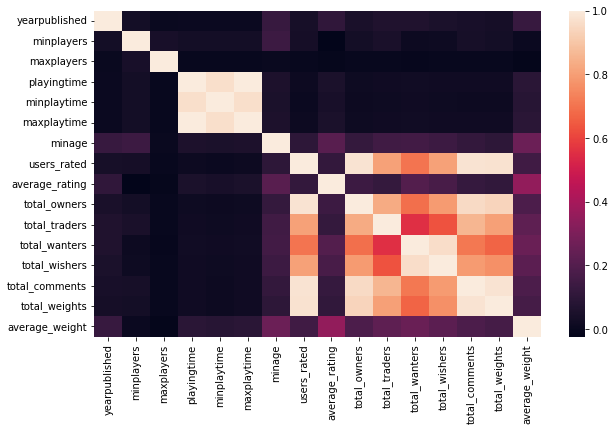

In [171]:
plt.figure(figsize = (10,6)) # Adjusting figure size.
sns.heatmap(df.corr()) # Displays heatmap of correlations between variables in ‘df’.

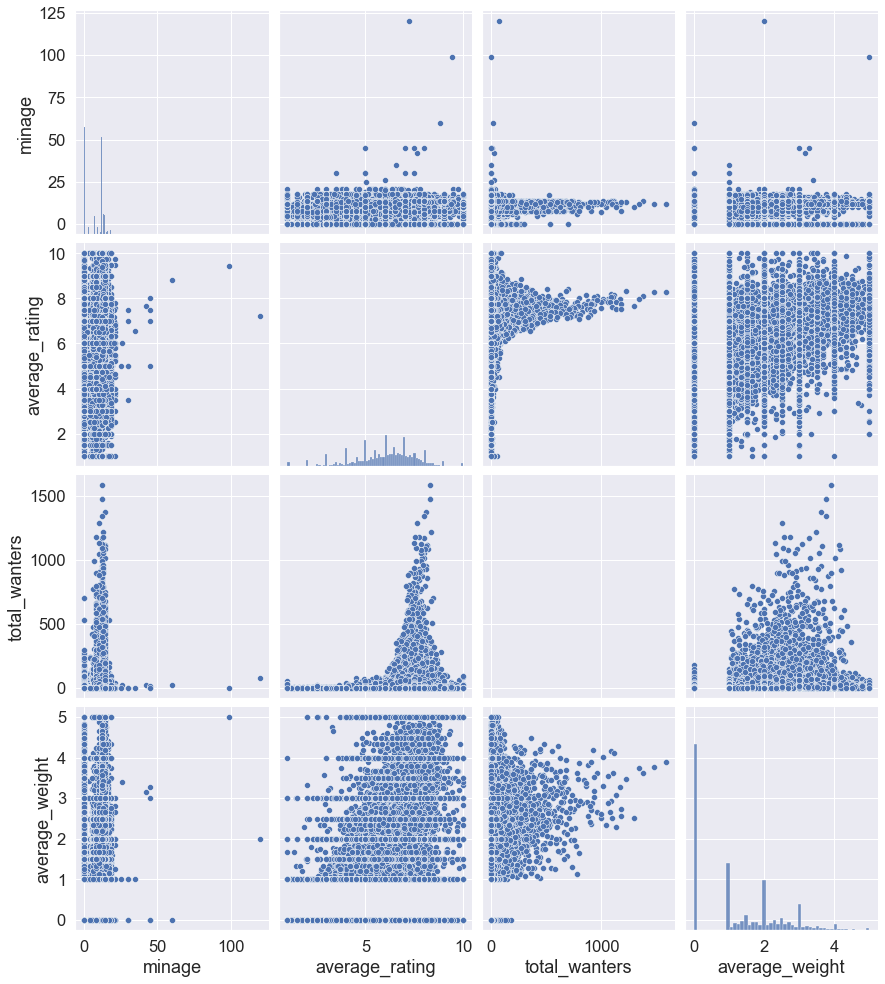

In [173]:
sns.set(font_scale = 1.5)
sns.pairplot(df[['minage','average_rating','total_wanters','average_weight']],height = 3.5,aspect = 0.9)

Is it right to compare board games based on ratings alone?

The ‘users_rated’ must also be considered before making a decision. It may be that board games with high ‘average_rating’ had less number of ‘users_rated’ which makes the ‘average_rating’ biased.

A new column called ‘new_users_rated’ is defined. ‘new_users_rated’ = 1 if ‘users_rated’ > 5000 and 0 otherwise.

C:\Users\Admin\anacondalastone\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='average_rating', ylabel='users_rated'>

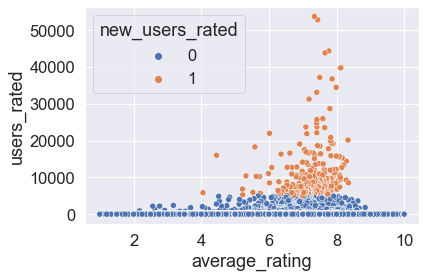

In [174]:
df['new_users_rated'] = df['users_rated'].apply(lambda x: 1 if x>5000 else 0)
sns.scatterplot('average_rating','users_rated',data = df,hue = 'new_users_rated')

# TRAINING THE MODEL

The data set has been preprocessed and is ready to be trained. A comparison is made between 2 models :- Linear Regression & Random Forest Regression.

Comparison of Linear Regression and Random Forest Regression

The comparison is made based on the cross validation score. The given training set is divided into 2 sets :- ‘Train_set’ and ‘Test_set’. The model is trained using a portion of ‘Train_set’. Cross validation score is calculated based on performance of trained model in remaining portion of ‘Train_set’.

There are various cross validation techniques which will be discussed later. Here K-Fold cross validation technique is used.

The training set is split into ‘Train_set’ and ‘Test_set’.

In [175]:
X = df.drop('average_rating',1) # X is input
y = df['average_rating'] # y is output
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.2) # Spitting into ‘Train_set’ and ‘Test_set’.

C:\Users\Admin\AppData\Local\Temp/ipykernel_10908/198515240.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



# Performance of Linear Regression model

In [179]:
a = LinearRegression().fit(X_train,y_train) # Fitting the model.
predictions = a.predict(X_test) # Test set is predicted.
#print(mean_squared_error(y_test,predictions)) # Mean squared error is calculated.

In [180]:
print('Mean Absolute Error Regression:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error Regression:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error Regression:', np.sqrt(mean_squared_error(y_test, predictions)))
print('r2_score Regression',r2_score(y_test, predictions))

Mean Absolute Error Regression: 1.0779547286946514
Mean Squared Error Regression: 2.064229202132275
Root Mean Squared Error Regression: 1.4367425664092628
r2_score Regression 0.16357692441666805


# Performance of Random Forest Regressor model

In [181]:
b = RandomForestRegressor().fit(X_train,y_train) # Fitting the model.
predictions = b.predict(X_test) # Test set is predicted.
#print(mean_squared_error(y_test,predictions)) # Mean squared error is calculated.

In [182]:
print('Mean Absolute Error RFR:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error RFR:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error RFR:', np.sqrt(mean_squared_error(y_test, predictions)))
print('r2_score RFR',r2_score(y_test, predictions))

Mean Absolute Error RFR: 0.8512143843531967
Mean Squared Error RFR: 1.4997777173681037
Root Mean Squared Error RFR: 1.224654121524973
r2_score RFR 0.3922919558755502


In [183]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,20,30,50,100,200,400,600,900,1000]
}

In [185]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=b,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1)

In [ ]:
rf_best_regressor3 = grid_search.fit(X_train, y_train)
rf_best_regressor3

Fitting 4 folds for each of 300 candidates, totalling 1200 fits


In [ ]:
rf_best_regressor3.best_estimator_

In [ ]:
predictions = rf_best_regressor3.predict(X_test)

In [ ]:
print('Mean Absolute Error RFR:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error RFR:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error RFR:', np.sqrt(mean_squared_error(y_test, predictions)))
print('r2_score RFR',r2_score(y_test, predictions))

In [187]:
prediction = b.predict(df.iloc[[42,97]].drop('average_rating',1))
print(prediction)

[7.8441064 7.6629614]


C:\Users\Admin\AppData\Local\Temp/ipykernel_10908/2114432154.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [189]:
df.iloc[[42,97]]['average_rating'] # Actual average ratings.

42    7.86088
97    7.67833
Name: average_rating, dtype: float64

in this two values, the actuals and predicted values are really close. 

# I had to stop the kernel bc it was taking awhile to do the parameter tuning. We have to do it and even if the R2 is not good we shoulddo more exploration to find better features selection that have more impact to the target variable and less correlation between them. 

# Even though the metrics are not optimal the purpose of this comparison between linear regression and random forest regression, it's to show that as expected the performance of Random Forest Regressor model is better than Linear Regression model for the given data set. This is because the board game data set is very large and it is difficult for the Linear Regression model to fit the data by a straight line.